---
# Capstone Scratchpad - Adam Talbot
---

---
## Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from datetime import datetime

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# plt.rc('figure', figsize=(13, 7))
# plt.rc('axes.spines', top=False, right=False)
# plt.rc('font', size=13)

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('tab20')
# pal = sns.set_palette('tab20')

---
## Acquire
---

In [30]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L1.xlsx')

In [31]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [32]:
df.head()

Year  Period   Area         Ownership  Industry Code  \
0  2017       1  Texas  Local Government           1011   
1  2017       1  Texas           Private           1011   
2  2017       1  Texas         Total All           1011   
3  2017       2  Texas           Private           1011   
4  2017       2  Texas         Total All           1011   

                       Industry  Level  Establishments  Firms  \
0  Natural Resources and Mining      1               3      3   
1  Natural Resources and Mining      1           19547  17486   
2  Natural Resources and Mining      1           19550  17489   
3  Natural Resources and Mining      1           19522  17454   
4  Natural Resources and Mining      1           19524  17456   

   Average Employment  Average Weekly Wage  Total Wages  Month 1 Employment  \
0                   6                  659        51409                   6   
1              269033                 2562   8959344530              266172   
2              269039                 2562   8959395939              266178   
3              278215                 1879   6796444215              274576   
4              278219                 1879   6796485889              274580   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0                   6                   6                      8   
1              269297              271629                      8   
2              269303              271635                      8   
3              278259              281810                      8   
4              278263              281814                      8   

   Total Employment  
0                18  
1            807098  
2            807116  
3            834645  
4            834657

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817 entries, 0 to 816
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year                   817 non-null    int64 
 1   Period                 817 non-null    int64 
 2   Area                   817 non-null    object
 3   Ownership              817 non-null    object
 4   Industry Code          817 non-null    int64 
 5   Industry               817 non-null    object
 6   Level                  817 non-null    int64 
 7   Establishments         817 non-null    int64 
 8   Firms                  817 non-null    int64 
 9   Average Employment     817 non-null    int64 
 10  Average Weekly Wage    817 non-null    int64 
 11  Total Wages            817 non-null    int64 
 12  Month 1 Employment     817 non-null    int64 
 13  Month 2 Employment     817 non-null    int64 
 14  Month 3 Employment     817 non-null    int64 
 15  Hierarchical Ordering  

---
## Prepare
---

In [34]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [35]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [36]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

In [37]:
# add a column named quarter and compare to period to see if this workedd
df['Q'] = df.Date.dt.quarter
(df.Q == df.Period).mean()

1.0

In [38]:
df.head()

Year  Period   Area         Ownership  Industry Code  \
0  2017       1  Texas  Local Government           1011   
1  2017       1  Texas           Private           1011   
2  2017       1  Texas         Total All           1011   
3  2017       2  Texas           Private           1011   
4  2017       2  Texas         Total All           1011   

                       Industry  Level  Establishments  Firms  \
0  Natural Resources and Mining      1               3      3   
1  Natural Resources and Mining      1           19547  17486   
2  Natural Resources and Mining      1           19550  17489   
3  Natural Resources and Mining      1           19522  17454   
4  Natural Resources and Mining      1           19524  17456   

   Average Employment  ...  Total Wages  Month 1 Employment  \
0                   6  ...        51409                   6   
1              269033  ...   8959344530              266172   
2              269039  ...   8959395939              266178   
3              278215  ...   6796444215              274576   
4              278219  ...   6796485889              274580   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0                   6                   6                      8   
1              269297              271629                      8   
2              269303              271635                      8   
3              278259              281810                      8   
4              278263              281814                      8   

   Total Employment  First Month Quarter       Date  Q  
0                18            1  2017-1 2017-01-01  1  
1            807098            1  2017-1 2017-01-01  1  
2            807116            1  2017-1 2017-01-01  1  
3            834645            4  2017-4 2017-04-01  2  
4            834657            4  2017-4 2017-04-01  2  

[5 rows x 21 columns]

---
## Exploration
---

### Level 1 Industries

---
#### One ownership category and a few industries

In [120]:
# create new df with just totals
total_df = df[df.Ownership == 'Total All']

In [121]:
# take a look at all industries represented
ind_list = total_df.Industry.value_counts().index.tolist()
# ind_list

In [122]:
# # try for a few industries
# nrm_t = total_df[total_df.Industry == 'Natural Resources and Mining']
# ttu_t = total_df[total_df.Industry == 'Trade, Transportation and Utilities']

In [123]:
# # try to plot total wages over time
# nrm_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Natural Resources and Mining')
# ttu_t[['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label='Trade, Transportation and Utilities')
# plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));

In [124]:
# # try to plot total wages over time
# nrm_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Natural Resources and Mining')
# ttu_t[['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label='Trade, Transportation and Utilities')
# plt.gca().set(ylabel = 'Total Employment', title='Natural Resources and Mining')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
#### One ownership category and all industries

In [125]:
# loop through list of industries and add to dict of dfs with key being industry name
df_dict = {}
for ind in ind_list:
    df_dict[ind] = total_df[total_df.Industry == ind]

In [127]:
# # loop through dictionary to plot all dfs on same plot
# for ind in ind_list:
#     df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
# plt.gca().set(ylabel = 'Total Wages ($)', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}B'.format(x / 1_000_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));

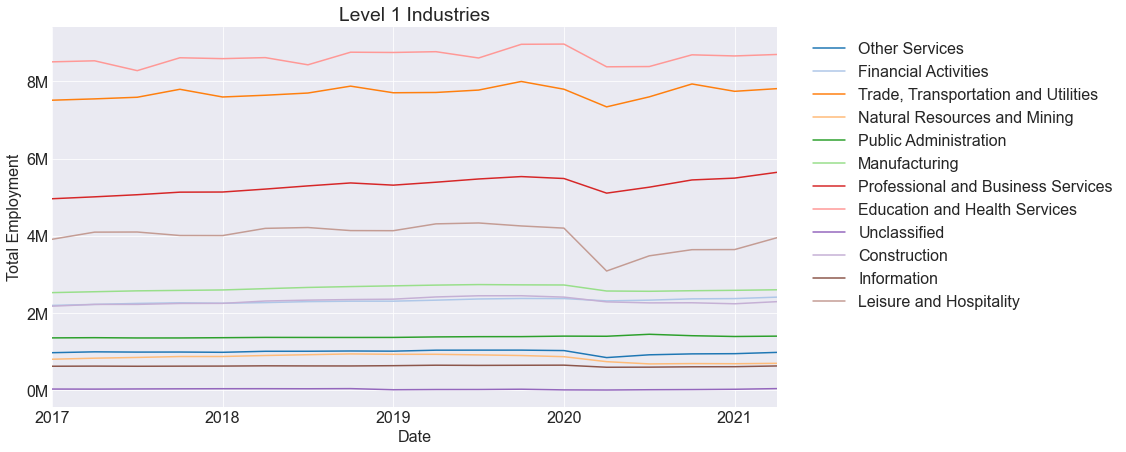

In [128]:
# do the same thing for wages
for ind in ind_list:
    df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1));

---
#### All ownership categories and all industries

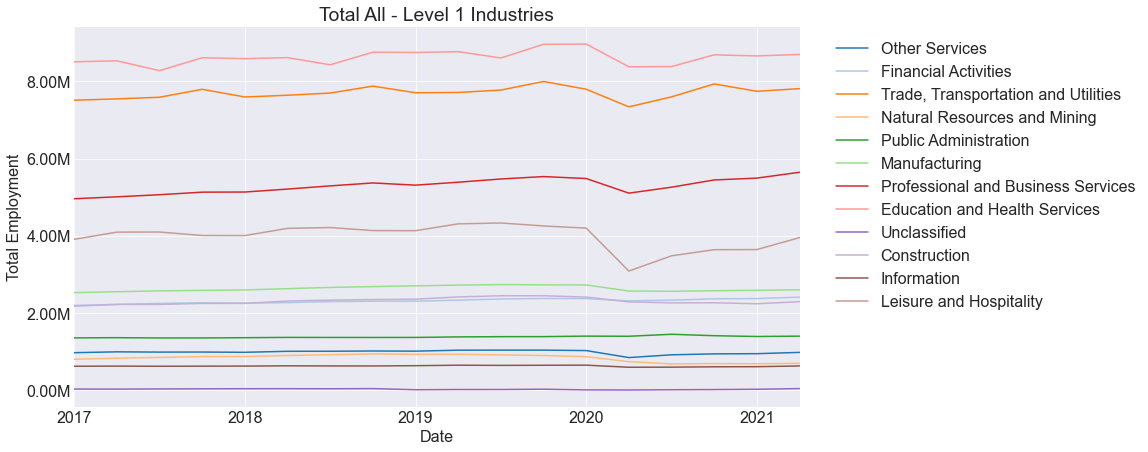

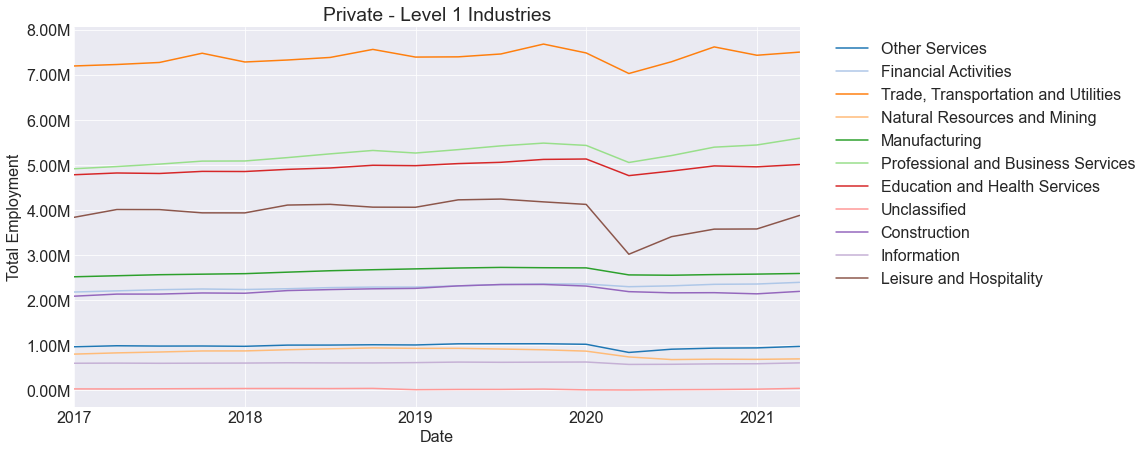

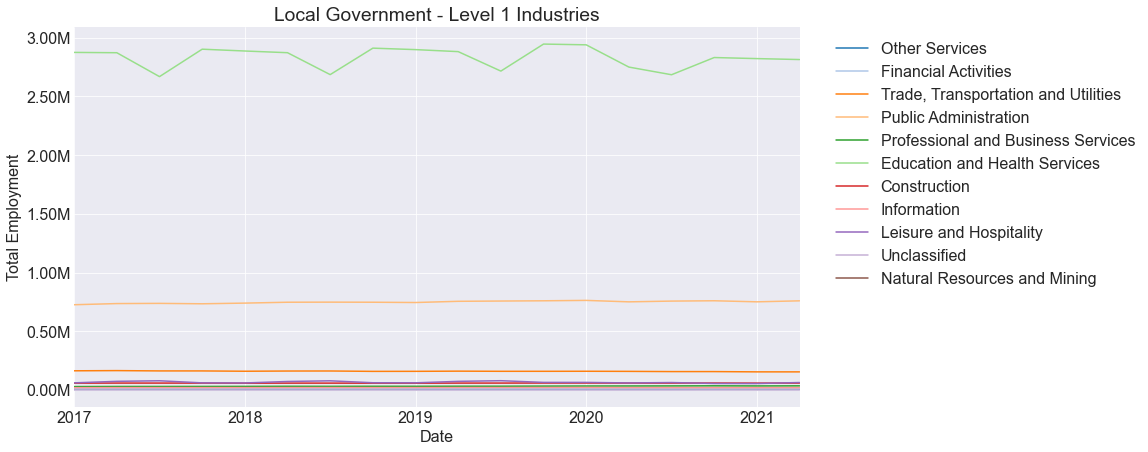

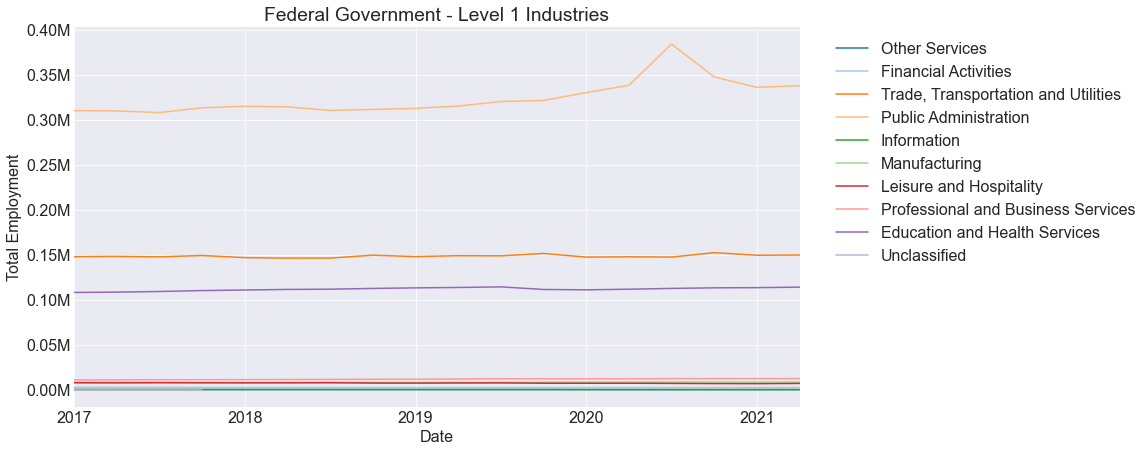

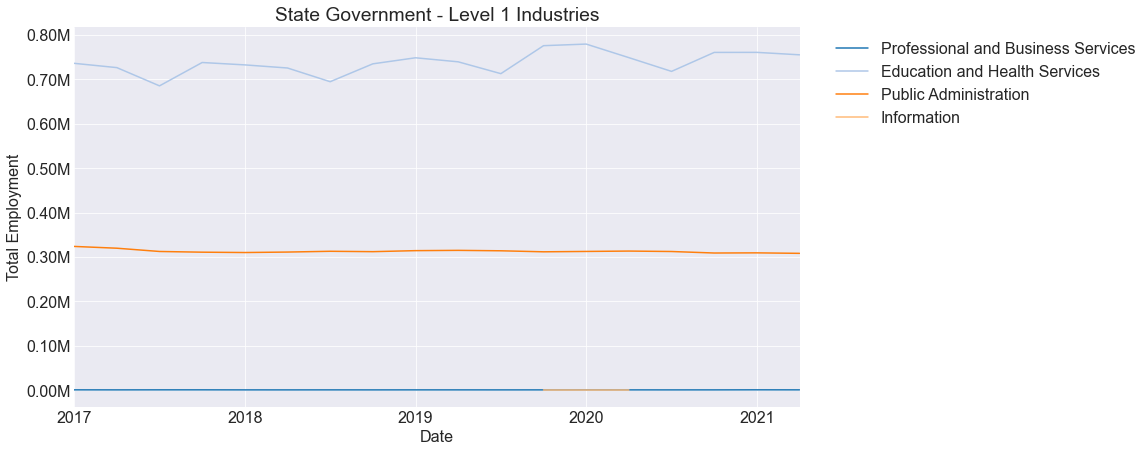

In [129]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 1 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 1 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

---
### Level 2 Industries
---

In [130]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L2.xlsx')

In [131]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [133]:
df.head()

Year  Period   Area  Ownership Industry Code  \
0  2017       1  Texas    Private            11   
1  2017       1  Texas  Total All            11   
2  2017       2  Texas    Private            11   
3  2017       2  Texas  Total All            11   
4  2017       3  Texas    Private            11   

                                     Industry  Level  Establishments  Firms  \
0  Agriculture, Forestry, Fishing and Hunting      2           10181   9992   
1  Agriculture, Forestry, Fishing and Hunting      2           10183   9994   
2  Agriculture, Forestry, Fishing and Hunting      2           10195  10005   
3  Agriculture, Forestry, Fishing and Hunting      2           10196  10006   
4  Agriculture, Forestry, Fishing and Hunting      2           10233  10046   

   Average Employment  Average Weekly Wage  Total Wages  Month 1 Employment  \
0               59382                  678    523308575               59862   
1               59385                  678    523329361               59865   
2               59688                  659    511656748               59346   
3               59689                  659    511662656               59347   
4               59478                  676    522814838               59186   

   Month 2 Employment  Month 3 Employment  Hierarchical Ordering  \
0               58939               59346                      9   
1               58942               59349                      9   
2               59635               60083                      9   
3               59636               60084                      9   
4               59716               59531                      9   

   Total Employment  
0            178147  
1            178156  
2            179064  
3            179067  
4            178433

In [134]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [135]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [136]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

---
#### All ownership categories and all industries

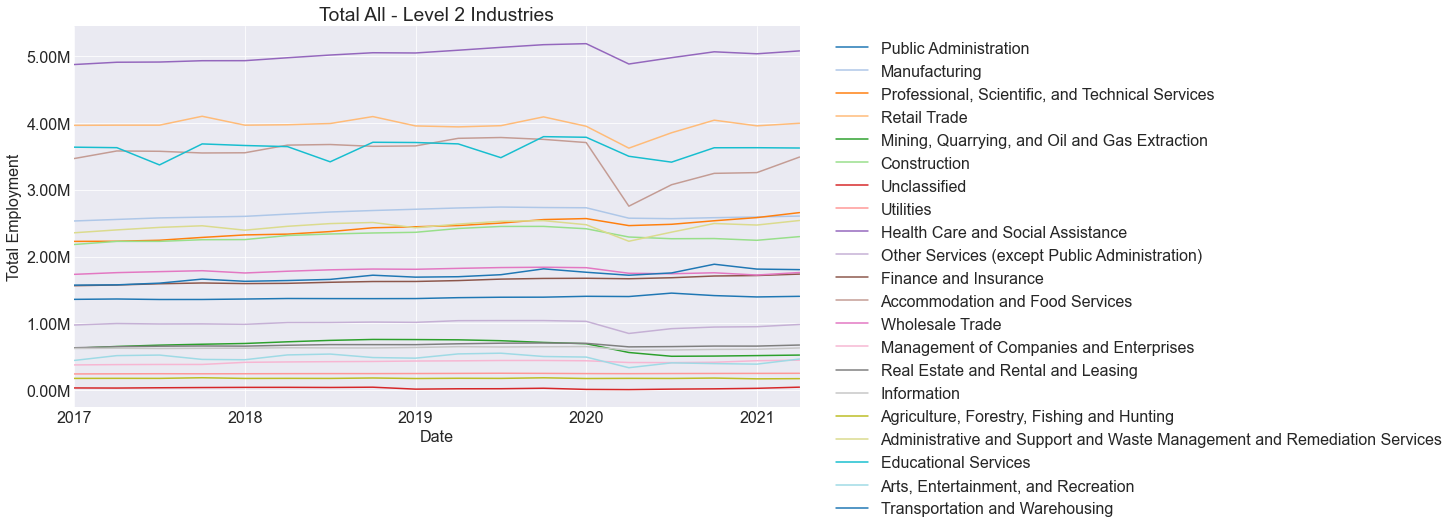

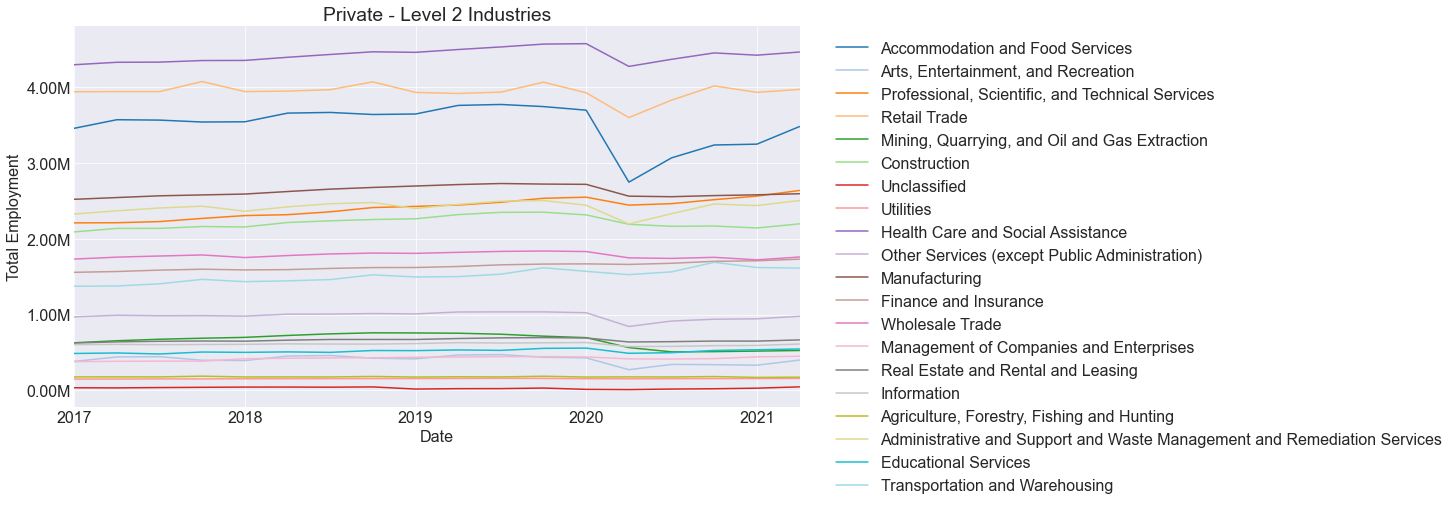

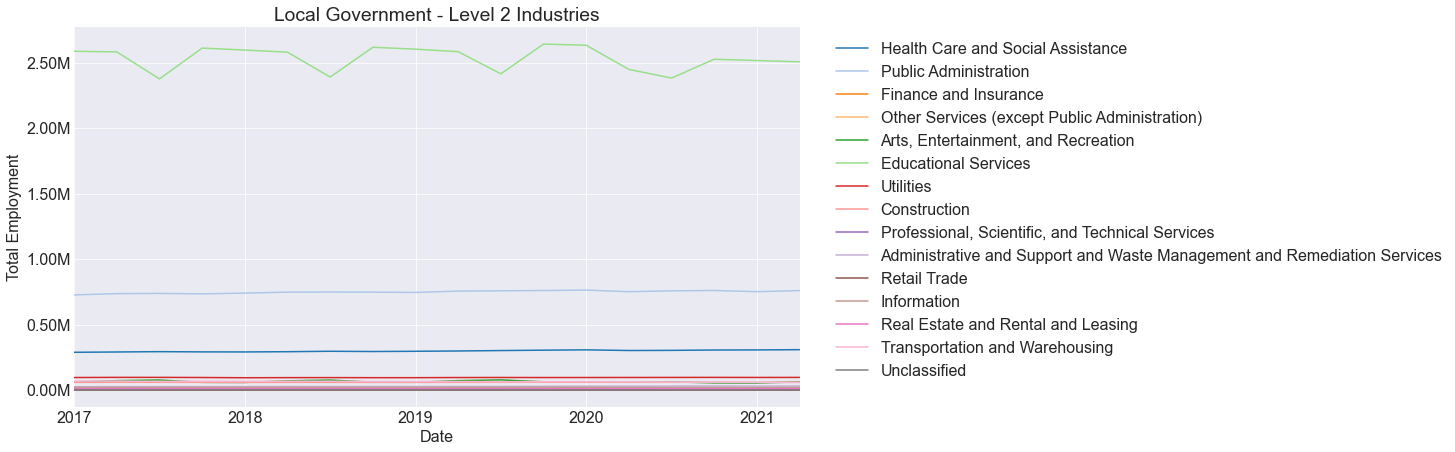

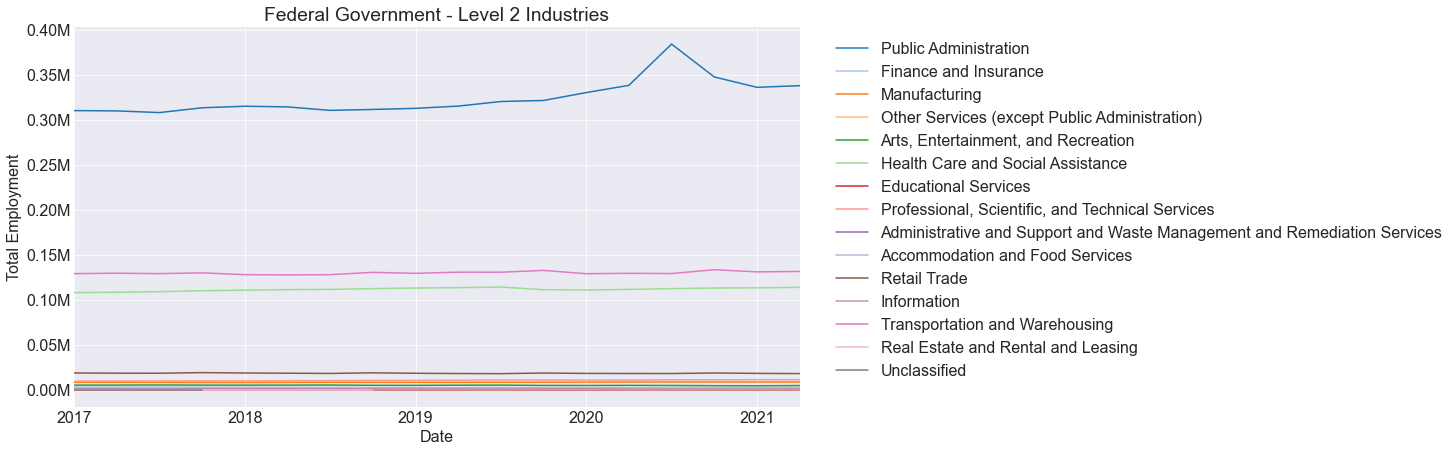

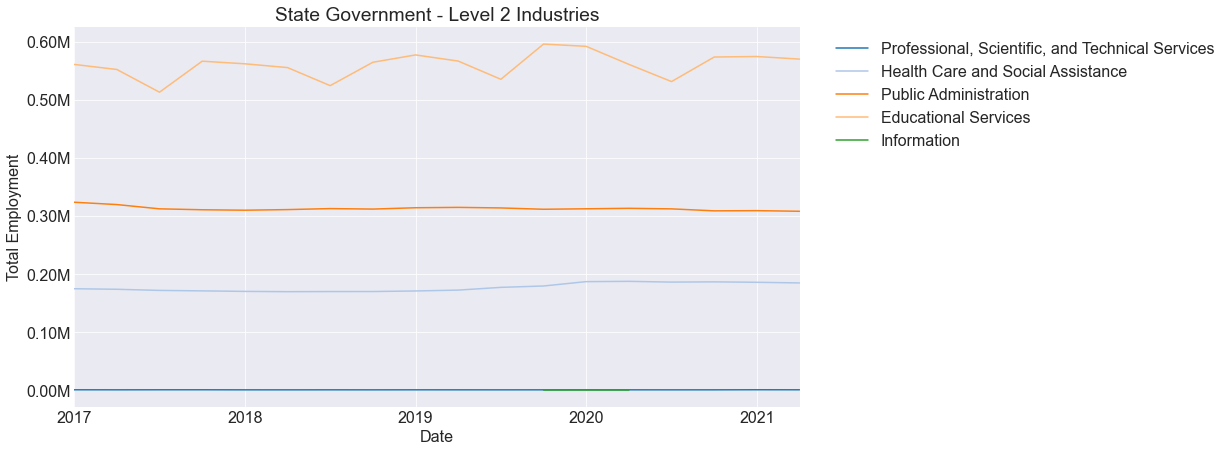

In [137]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 2 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 2 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

---
### Level 3 Industries
---

In [197]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L3.xlsx')

In [198]:
# add a column for total employment for that row
df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

In [199]:
# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

In [200]:
# add first month to year as strings 
df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

In [201]:
# make a new column that is datetime for first day of each quarter for x axis when plotting
df['Date'] = pd.to_datetime(df.Quarter)

---
#### All ownership categories and all industries

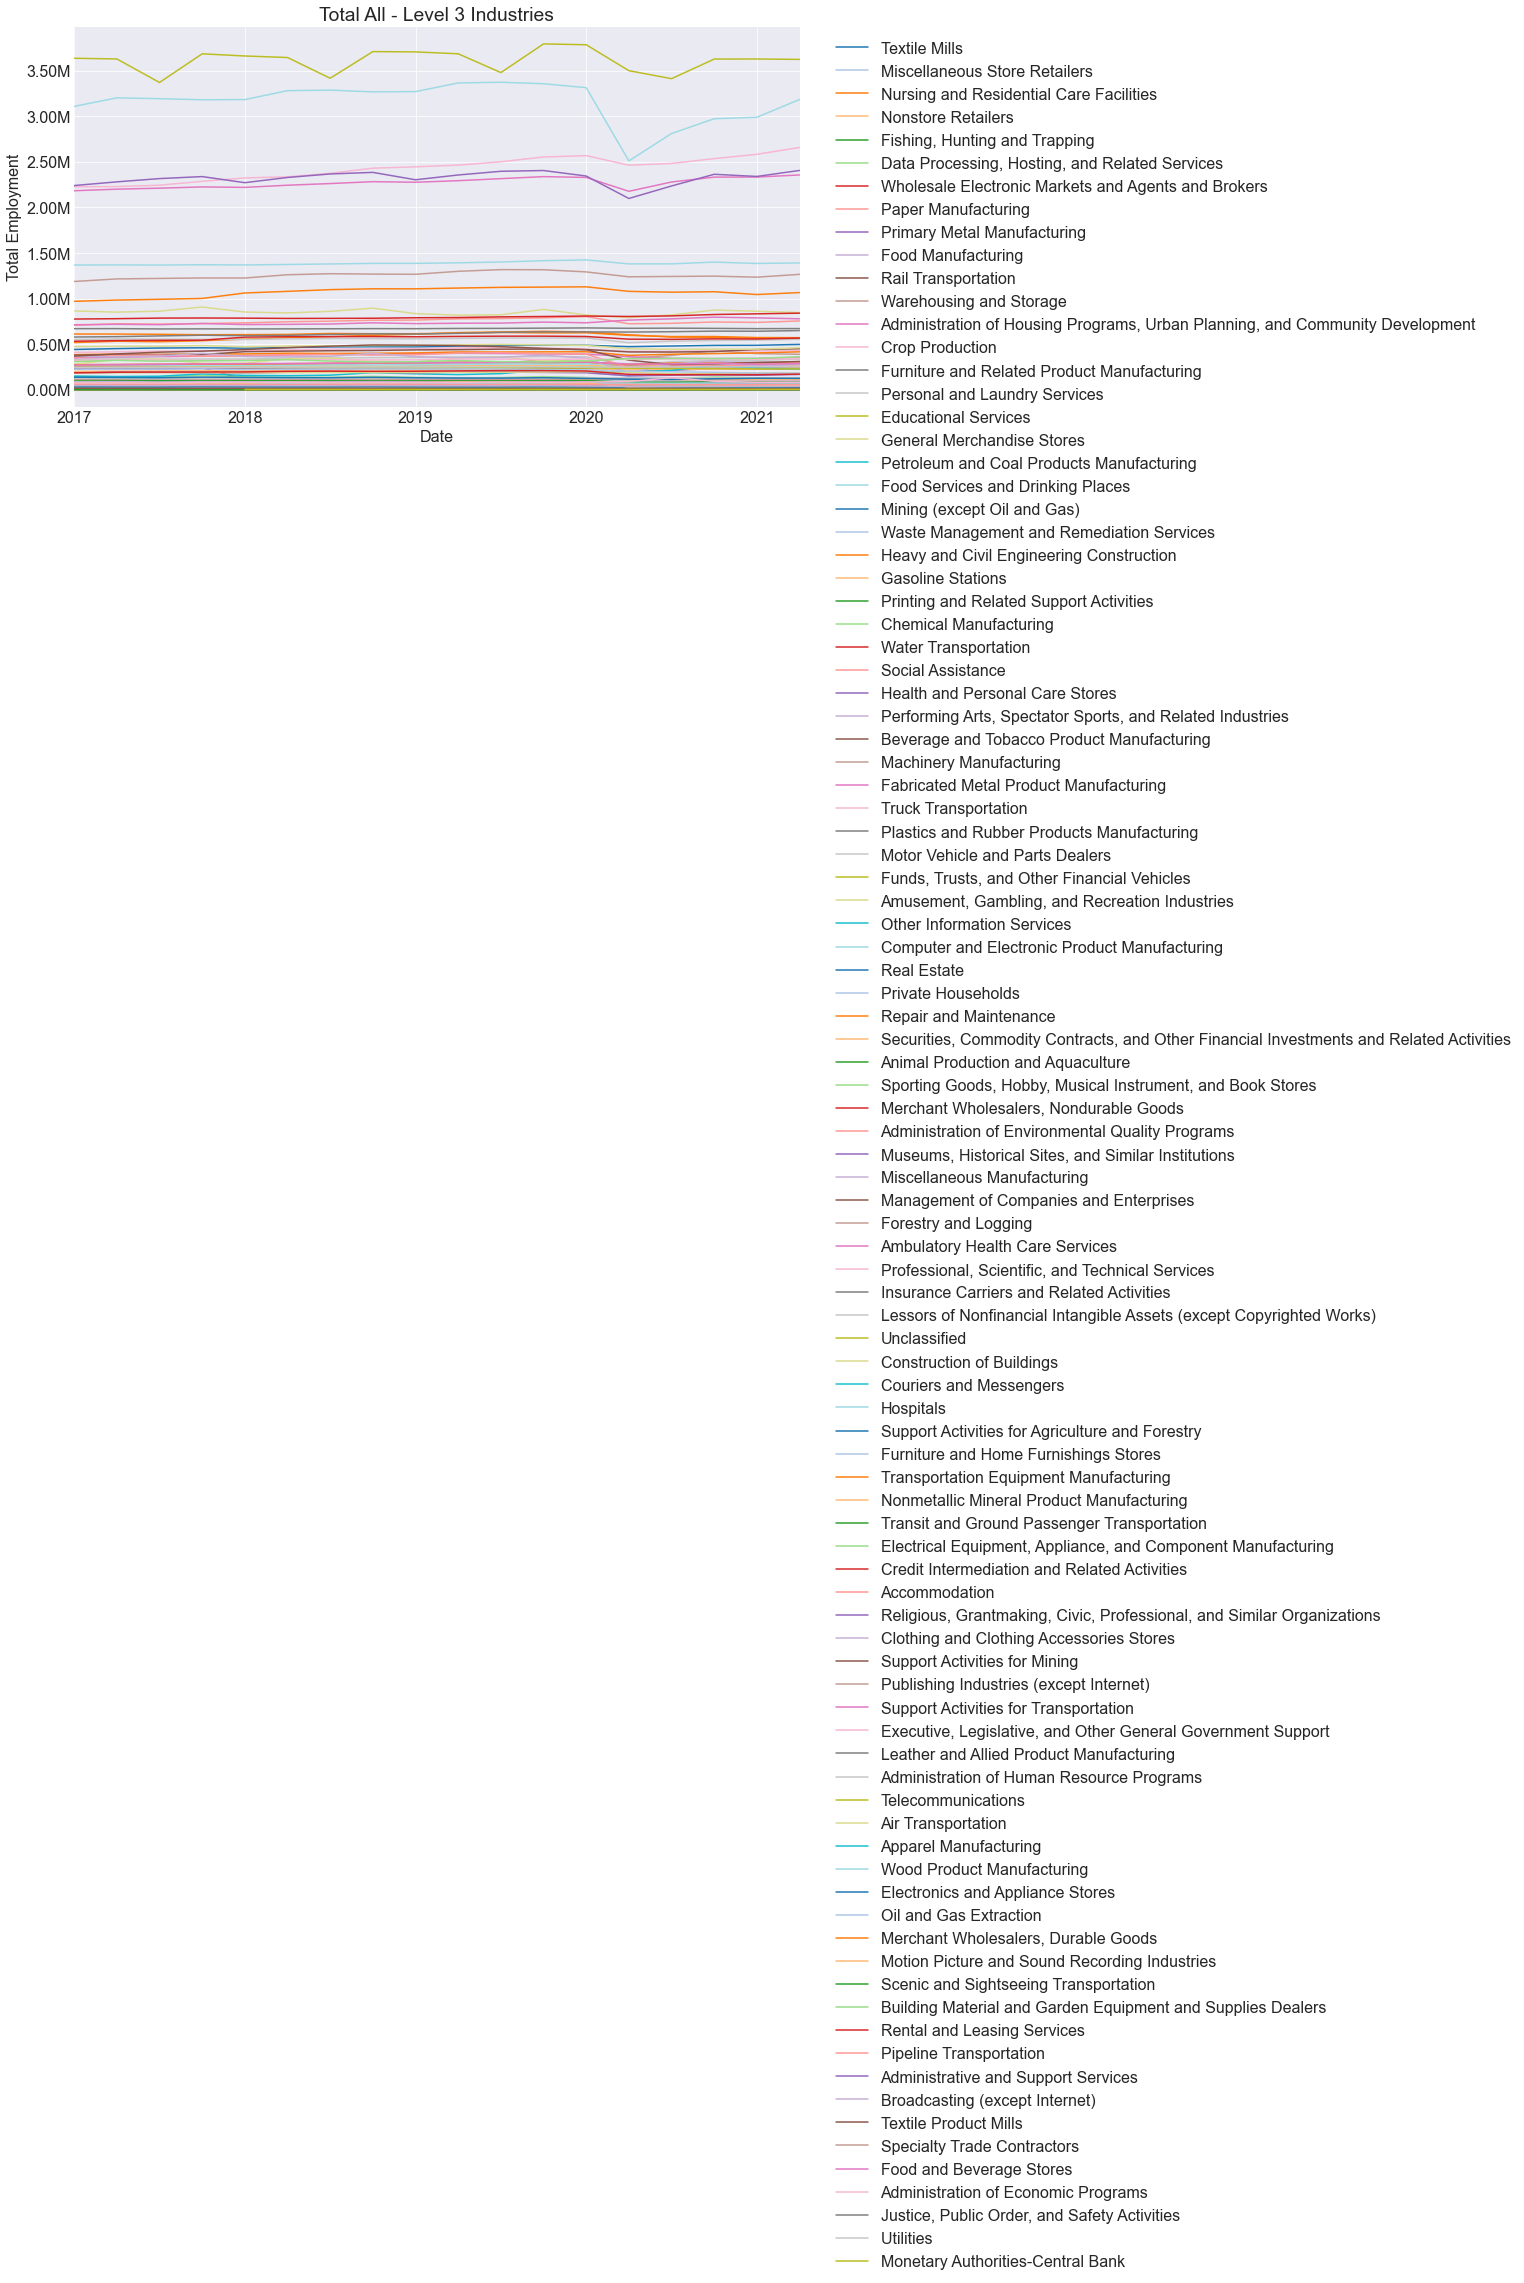

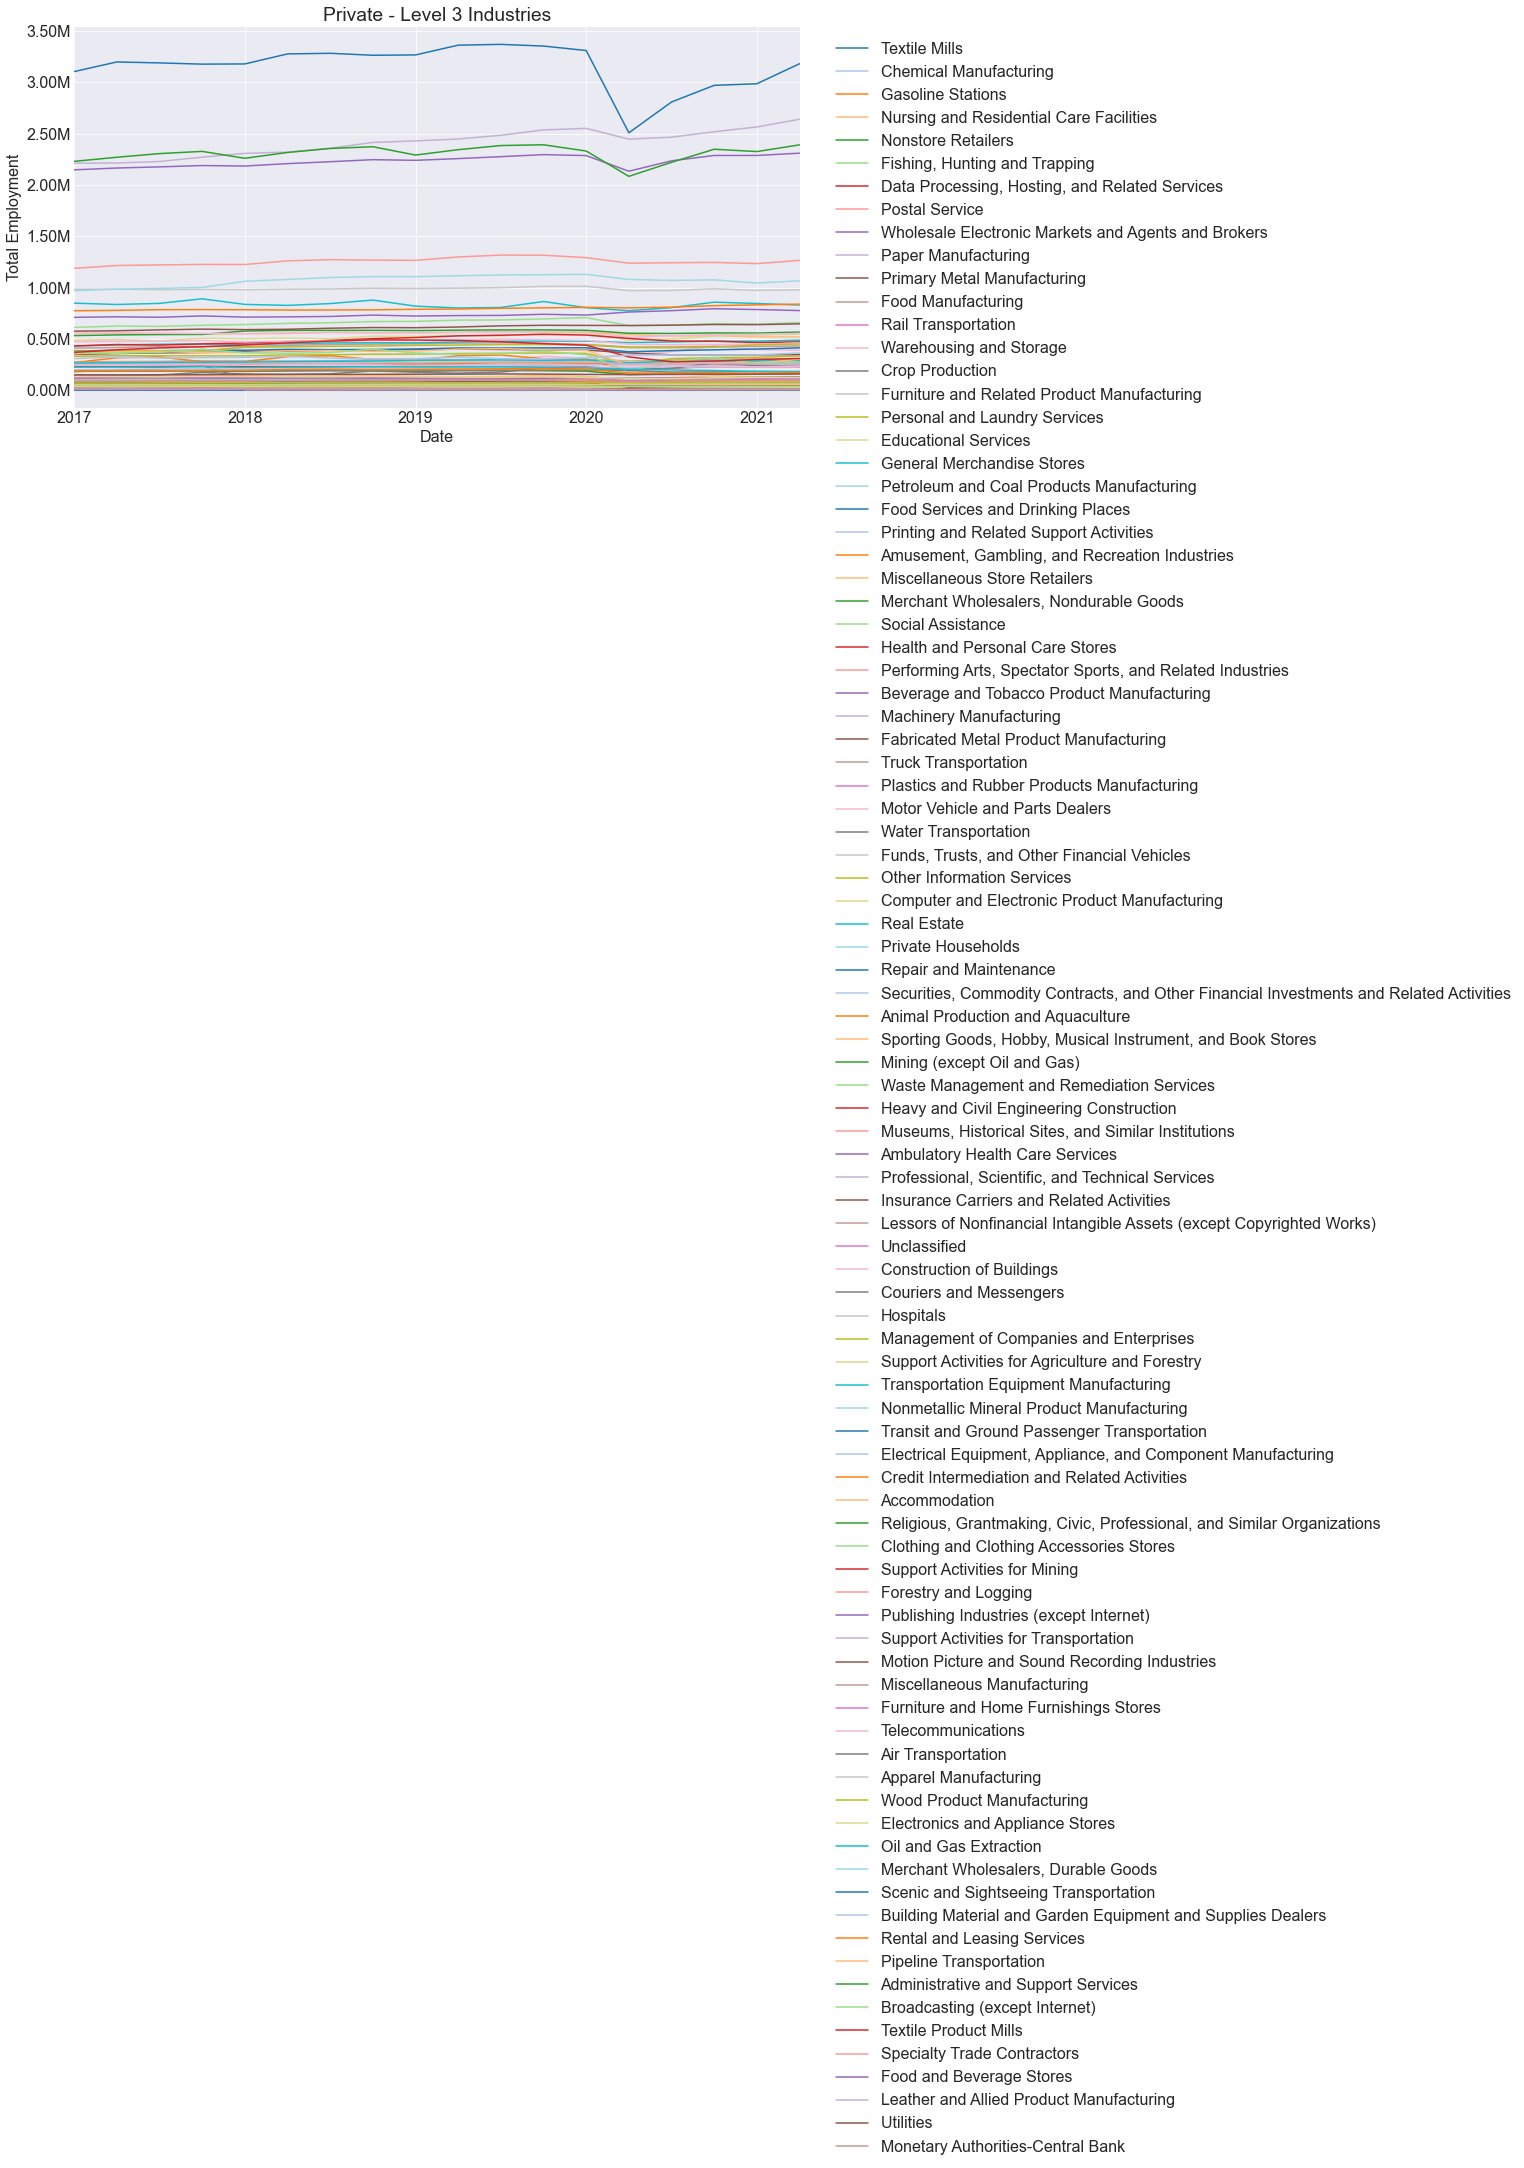

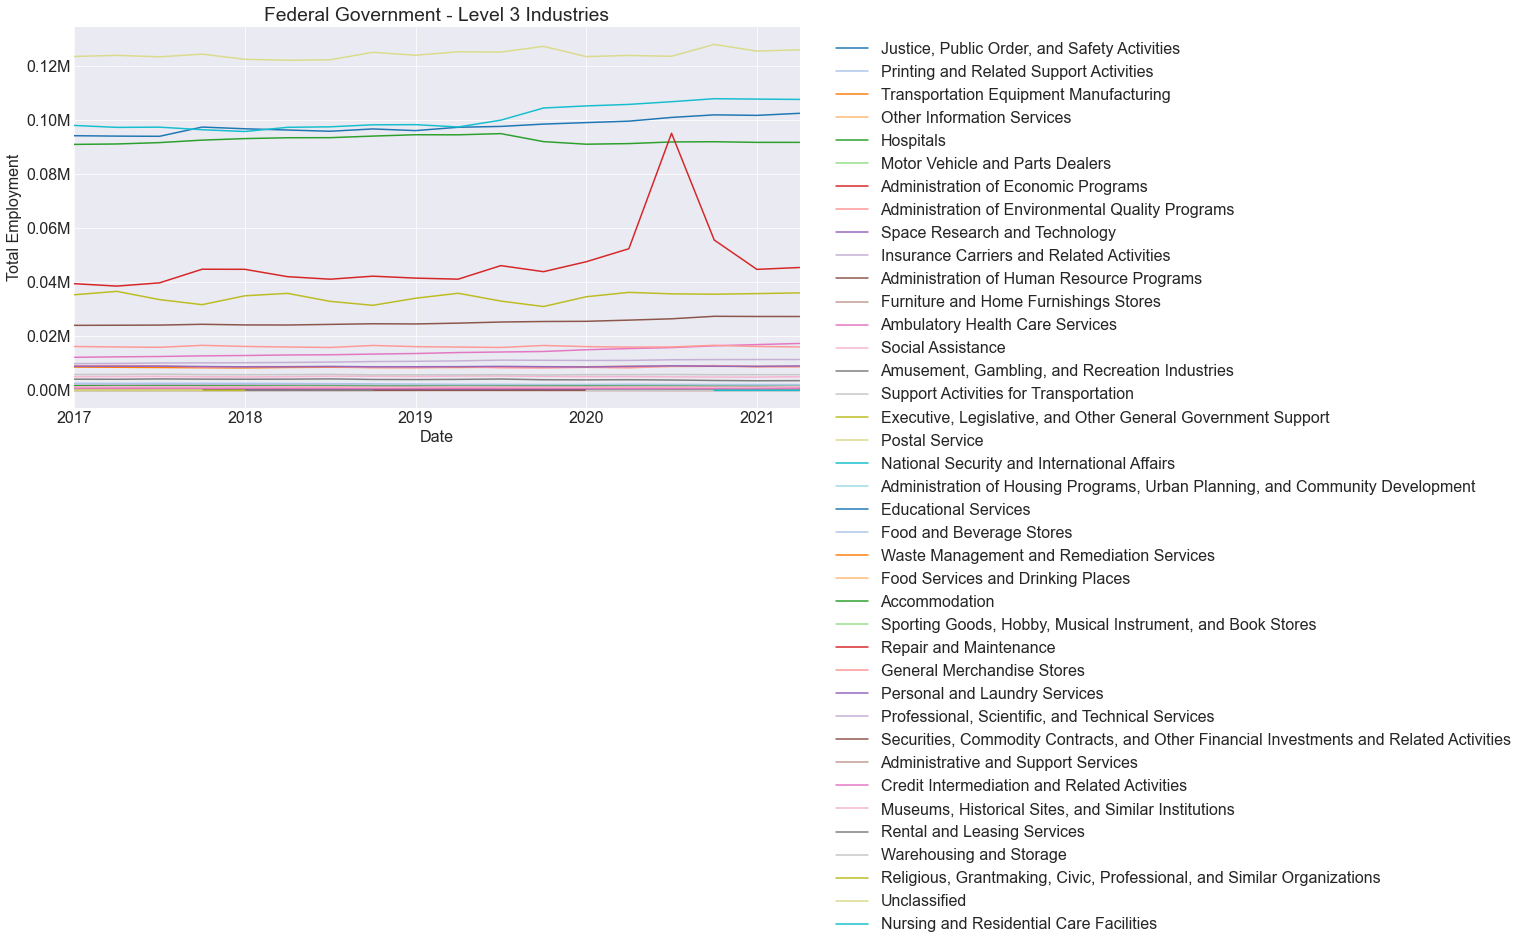

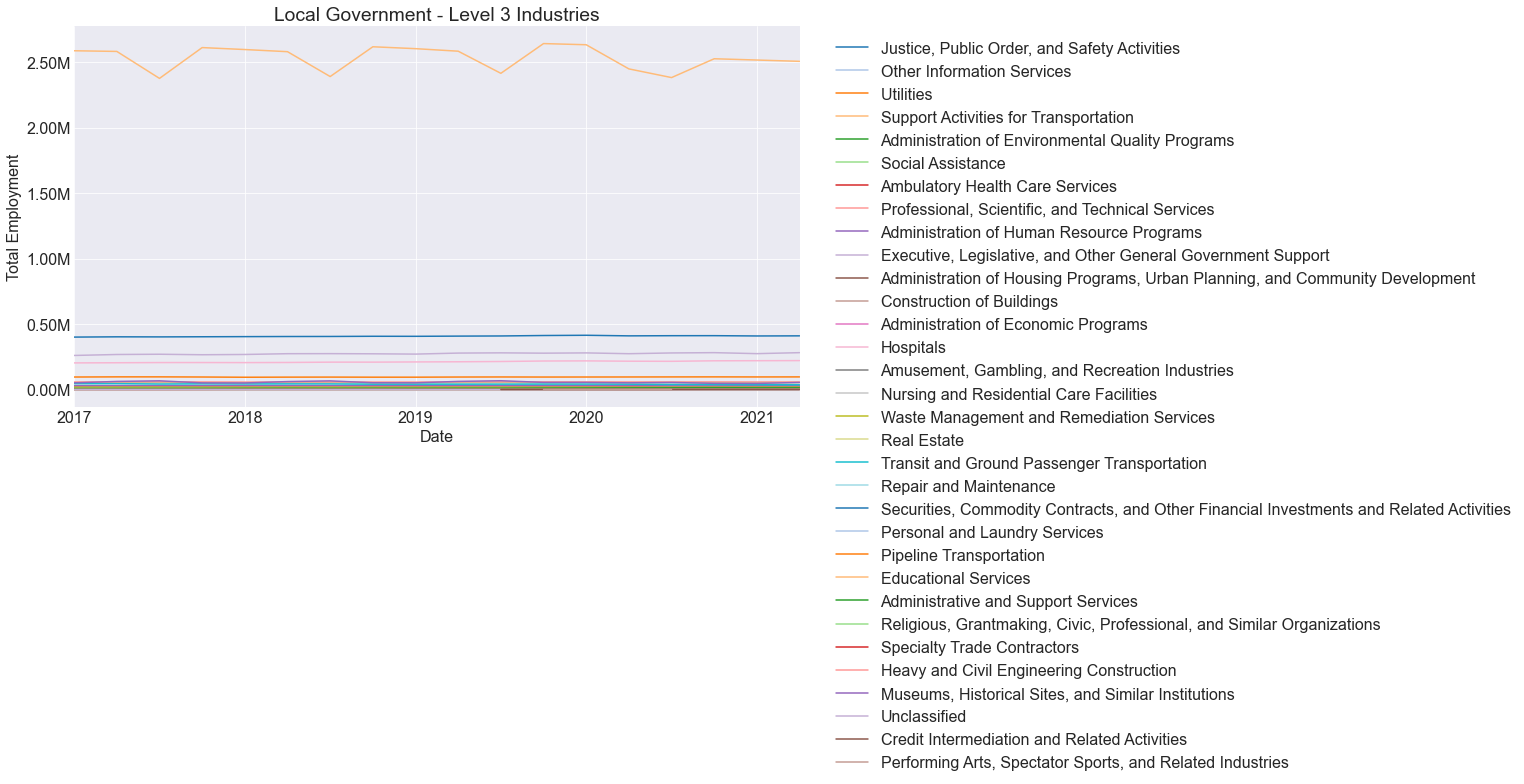

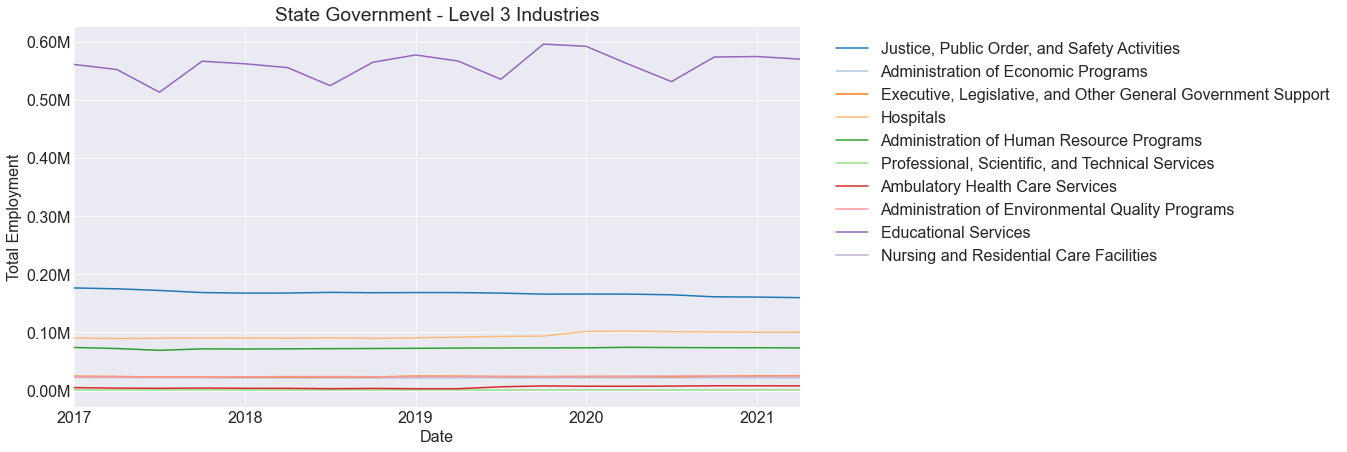

In [184]:
# do this for all ownership categories in loop
ownership_list = df.Ownership.value_counts().index.tolist()

ownership_df_dict = {}
for own in ownership_list:
    ownership_df_dict[own] = df[df.Ownership == own]

for own in ownership_list:
    ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - Level 1 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

# works but has way too many industries to fit on one plot

In [185]:
# write a function that uses 3-digit industry code to get 2 digit industry code and then convert that to industry name 
# (use map function after creating dictionary of codes to names)
df['Code'] = df['Industry Code'].astype('string').apply(lambda x: x[:2])

In [186]:
# df.Code.value_counts().sort_index()

In [187]:
# create mapping dictionary to get industries associated with 2-digit codes
code_mapping_dict = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining, Quarrying, and Oil and Gas Extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate and Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration',
    '99' : 'Unclassified'
}

In [188]:
# create new column with industry names using map function
df['Parent Industry'] = df.Code.map(code_mapping_dict)

In [189]:
# get list of all unique parent industries
par_ind_list = df['Parent Industry'].value_counts().index.tolist()
par_ind_list

['Manufacturing',
 'Retail Trade',
 'Transportation and Warehousing',
 'Public Administration',
 'Health Care and Social Assistance',
 'Information',
 'Other Services (except Public Administration)',
 'Finance and Insurance',
 'Arts, Entertainment, and Recreation',
 'Agriculture, Forestry, Fishing and Hunting',
 'Construction',
 'Administrative and Support and Waste Management and Remediation Services',
 'Real Estate and Rental and Leasing',
 'Accommodation and Food Services',
 'Wholesale Trade',
 'Mining, Quarrying, and Oil and Gas Extraction',
 'Professional, Scientific, and Technical Services',
 'Educational Services',
 'Unclassified',
 'Utilities',
 'Management of Companies and Enterprises']

In [190]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

In [191]:
# for par in par_ind_list:
#     df = par_ind_df_dict[par]
    
#     ownership_list = df.Ownership.value_counts().index.tolist()
    
#     ownership_df_dict = {}
#     for own in ownership_list:
#         ownership_df_dict[own] = df[df.Ownership == own]
    
#     for own in ownership_list:
#         ind_list = ownership_df_dict[own].Industry.value_counts().index.tolist()
#         industry_df_dict = {}
#         for ind in ind_list:
#             industry_df_dict[ind] = ownership_df_dict[own][ownership_df_dict[own].Industry == ind]
# #         for ind in ind_list:
# #             industry_df_dict[ind][['Date', 'Total Wages']].set_index('Date')['Total Wages'].plot(label=ind)
# #         plt.gca().set(ylabel = 'Total Wages ($)', title=f'{own} - {par} - Level 3 Industries')
# #         plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}B'.format(x / 1_000_000_000))
# #         plt.legend(bbox_to_anchor= (1.03,1))
# #         plt.show()
#         for ind in ind_list:
#             industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#         plt.gca().set(ylabel = 'Total Employment', title=f'{own} - {par} - Level 3 Industries')
#         plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#         plt.legend(bbox_to_anchor= (1.03,1))
#         plt.show()

---
#### Just Total All, all industries

In [2]:
# get data for highest (most general) level of industry classification
df = pd.read_excel('QCEW-TX-L3.xlsx')

# add a column for total employment for that row
# df['Total Employment'] = df['Month 1 Employment'] + df['Month 2 Employment'] + df['Month 3 Employment']

# figure out a way to convert the year and period columns into a single datetime format for plotting
# Convert the period number into the number of the first month for each quarter
# Q1 - 1, Q2 - 4, Q3 - 7, Q4 - 10
# df['First Month'] = df.Period.apply(lambda x: '1' if x == 1 else '4' if x == 2 else '7' if x == 3 else '10')

# add first month to year as strings 
# df['Quarter'] = df.Year.astype('string') + '-' + df['First Month']

# make a new column that is datetime for first day of each quarter for x axis when plotting
# df['Date'] = pd.to_datetime(df.Quarter)

# only total
df = df[df.Ownership == 'Total All']
# I only want to keep a few columns
df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']]

In [3]:
# # we are looking at a total of 97 industries on a single plot
# ind_list = df.Industry.value_counts().index.tolist()
# #ind_list

# industry_df_dict = {}
# for ind in ind_list:
#     industry_df_dict[ind] = df[df.Industry == ind]

# for ind in ind_list:
#     industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{own} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.2f}M'.format(x / 1_000_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
# plt.show()

In [4]:
df.head()

Year  Period  Industry Code         Industry  Month 1 Employment  \
1  2017       1            111  Crop Production               19992   
3  2017       2            111  Crop Production               21337   
5  2017       3            111  Crop Production               20982   
7  2017       4            111  Crop Production               21747   
9  2018       1            111  Crop Production               19531   

   Month 2 Employment  Month 3 Employment  
1               20513               21298  
3               21000               21024  
5               20754               20583  
7               22210               21254  
9               20177               20942

In [5]:
# take a look at current number rows
df.shape

(1735, 7)

In [6]:
# we want to create 3 rows for each current row, so our new df should have this many rows
1735 * 3

5205

In [7]:
df.Industry.nunique()

97

In [8]:
# I want to take values for columns 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment' and pivot them into rows while changing dates to year-month-01 for each month
df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment')

In [9]:
df.shape

(5205, 6)

In [10]:
# now let's create plots for each industry
df.head()

Year  Period  Industry Code         Industry               Month  \
0  2017       1            111  Crop Production  Month 1 Employment   
1  2017       2            111  Crop Production  Month 1 Employment   
2  2017       3            111  Crop Production  Month 1 Employment   
3  2017       4            111  Crop Production  Month 1 Employment   
4  2018       1            111  Crop Production  Month 1 Employment   

   Total Employment  
0             19992  
1             21337  
2             20982  
3             21747  
4             19531

In [11]:
df[(df.Year == 2017) & (df.Industry == 'Crop Production')]

Year  Period  Industry Code         Industry               Month  \
0     2017       1            111  Crop Production  Month 1 Employment   
1     2017       2            111  Crop Production  Month 1 Employment   
2     2017       3            111  Crop Production  Month 1 Employment   
3     2017       4            111  Crop Production  Month 1 Employment   
1735  2017       1            111  Crop Production  Month 2 Employment   
1736  2017       2            111  Crop Production  Month 2 Employment   
1737  2017       3            111  Crop Production  Month 2 Employment   
1738  2017       4            111  Crop Production  Month 2 Employment   
3470  2017       1            111  Crop Production  Month 3 Employment   
3471  2017       2            111  Crop Production  Month 3 Employment   
3472  2017       3            111  Crop Production  Month 3 Employment   
3473  2017       4            111  Crop Production  Month 3 Employment   

      Total Employment  
0                19992  
1                21337  
2                20982  
3                21747  
1735             20513  
1736             21000  
1737             20754  
1738             22210  
3470             21298  
3471             21024  
3472             20583  
3473             21254

In [12]:
# use string method to pull out numbers from Month column
df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])

In [13]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment
0  2017       1            111  Crop Production      1             19992
1  2017       2            111  Crop Production      1             21337
2  2017       3            111  Crop Production      1             20982
3  2017       4            111  Crop Production      1             21747
4  2018       1            111  Crop Production      1             19531

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              5205 non-null   int64 
 1   Period            5205 non-null   int64 
 2   Industry Code     5205 non-null   int64 
 3   Industry          5205 non-null   object
 4   Month             5205 non-null   int64 
 5   Total Employment  5205 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 244.1+ KB


https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe

In [15]:
# create a function that takes each row and creates a date column for the observation
def extract_date(df):
    if (df[1] == 1) & (df[4] == 1): # first quarter, first month
        return str(df[0]) + '-' + '01' # January
    elif (df[1] == 1) & (df[4] == 2):
        return str(df[0]) + '-' + '02'
    elif (df[1] == 1) & (df[4] == 3):
        return str(df[0]) + '-' + '03'
    elif (df[1] == 2) & (df[4] == 1):
        return str(df[0]) + '-' + '04'
    elif (df[1] == 2) & (df[4] == 2):
        return str(df[0]) + '-' + '05'
    elif (df[1] == 2) & (df[4] == 3):
        return str(df[0]) + '-' + '06'
    elif (df[1] == 3) & (df[4] == 1):
        return str(df[0]) + '-' + '07'
    elif (df[1] == 3) & (df[4] == 2):
        return str(df[0]) + '-' + '08'
    elif (df[1] == 3) & (df[4] == 3):
        return str(df[0]) + '-' + '09'
    elif (df[1] == 4) & (df[4] == 1):
        return str(df[0]) + '-' + '10'
    elif (df[1] == 4) & (df[4] == 2):
        return str(df[0]) + '-' + '11'
    elif (df[1] == 4) & (df[4] == 3):
        return str(df[0]) + '-' + '12'

In [16]:
df['Date'] = df.apply(extract_date, axis=1)

In [17]:
df.Date = pd.to_datetime(df.Date)

In [18]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date  
0 2017-01-01  
1 2017-04-01  
2 2017-07-01  
3 2017-10-01  
4 2018-01-01

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Year              5205 non-null   int64         
 1   Period            5205 non-null   int64         
 2   Industry Code     5205 non-null   int64         
 3   Industry          5205 non-null   object        
 4   Month             5205 non-null   int64         
 5   Total Employment  5205 non-null   int64         
 6   Date              5205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 284.8+ KB


<AxesSubplot:xlabel='Date'>

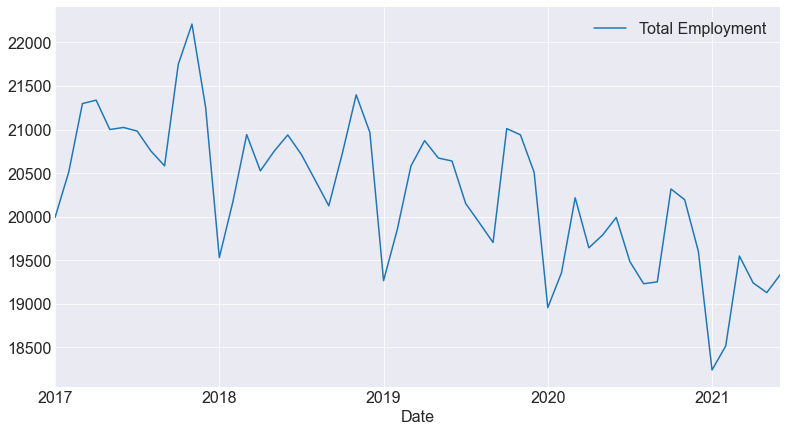

In [20]:
# now plot these for one industry
df[df.Industry == 'Crop Production'].sort_values(by='Date')[['Date', 'Total Employment']].set_index('Date').sort_index().plot()

In [21]:
# now plot for each subsector

In [22]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date  
0 2017-01-01  
1 2017-04-01  
2 2017-07-01  
3 2017-10-01  
4 2018-01-01

In [23]:
# write a function that uses 3-digit industry code to get 2 digit industry code and then convert that to industry name 
# (use map function after creating dictionary of codes to names)
df['Code'] = df['Industry Code'].astype('string').apply(lambda x: x[:2])

In [24]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date Code  
0 2017-01-01   11  
1 2017-04-01   11  
2 2017-07-01   11  
3 2017-10-01   11  
4 2018-01-01   11

In [25]:
# create mapping dictionary to get industries associated with 2-digit codes
code_mapping_dict = {
    '11' : 'Agriculture, Forestry, Fishing and Hunting',
    '21' : 'Mining, Quarrying, and Oil and Gas Extraction',
    '22' : 'Utilities',
    '23' : 'Construction',
    '31' : 'Manufacturing',
    '32' : 'Manufacturing',
    '33' : 'Manufacturing',
    '42' : 'Wholesale Trade',
    '44' : 'Retail Trade',
    '45' : 'Retail Trade',
    '48' : 'Transportation and Warehousing',
    '49' : 'Transportation and Warehousing',
    '51' : 'Information',
    '52' : 'Finance and Insurance',
    '53' : 'Real Estate and Rental and Leasing',
    '54' : 'Professional, Scientific, and Technical Services',
    '55' : 'Management of Companies and Enterprises',
    '56' : 'Administrative and Support and Waste Management and Remediation Services',
    '61' : 'Educational Services',
    '62' : 'Health Care and Social Assistance',
    '71' : 'Arts, Entertainment, and Recreation',
    '72' : 'Accommodation and Food Services',
    '81' : 'Other Services (except Public Administration)',
    '92' : 'Public Administration',
    '99' : 'Unclassified'
}

In [26]:
# create new column with industry names using map function
df['Parent Industry'] = df.Code.map(code_mapping_dict)

In [27]:
df.head()

Year  Period  Industry Code         Industry  Month  Total Employment  \
0  2017       1            111  Crop Production      1             19992   
1  2017       2            111  Crop Production      1             21337   
2  2017       3            111  Crop Production      1             20982   
3  2017       4            111  Crop Production      1             21747   
4  2018       1            111  Crop Production      1             19531   

        Date Code                             Parent Industry  
0 2017-01-01   11  Agriculture, Forestry, Fishing and Hunting  
1 2017-04-01   11  Agriculture, Forestry, Fishing and Hunting  
2 2017-07-01   11  Agriculture, Forestry, Fishing and Hunting  
3 2017-10-01   11  Agriculture, Forestry, Fishing and Hunting  
4 2018-01-01   11  Agriculture, Forestry, Fishing and Hunting

In [28]:
# get list of all unique parent industries
par_ind_list = df['Parent Industry'].value_counts().index.tolist()

In [29]:
# # create a dictionary with subset dfs for each parent industry
# par_ind_df_dict = {}
# for ind in par_ind_list:
#     par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

# for par in par_ind_list:
#     df = par_ind_df_dict[par]
#     ind_list = df.Industry.value_counts().index.tolist()
#     industry_df_dict = {}
#     for ind in ind_list:
#         industry_df_dict[ind] = df[df.Industry == ind]
#     for ind in ind_list:
#         industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
#     plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
#     plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
#     plt.legend(bbox_to_anchor= (1.03,1))
#     plt.show()

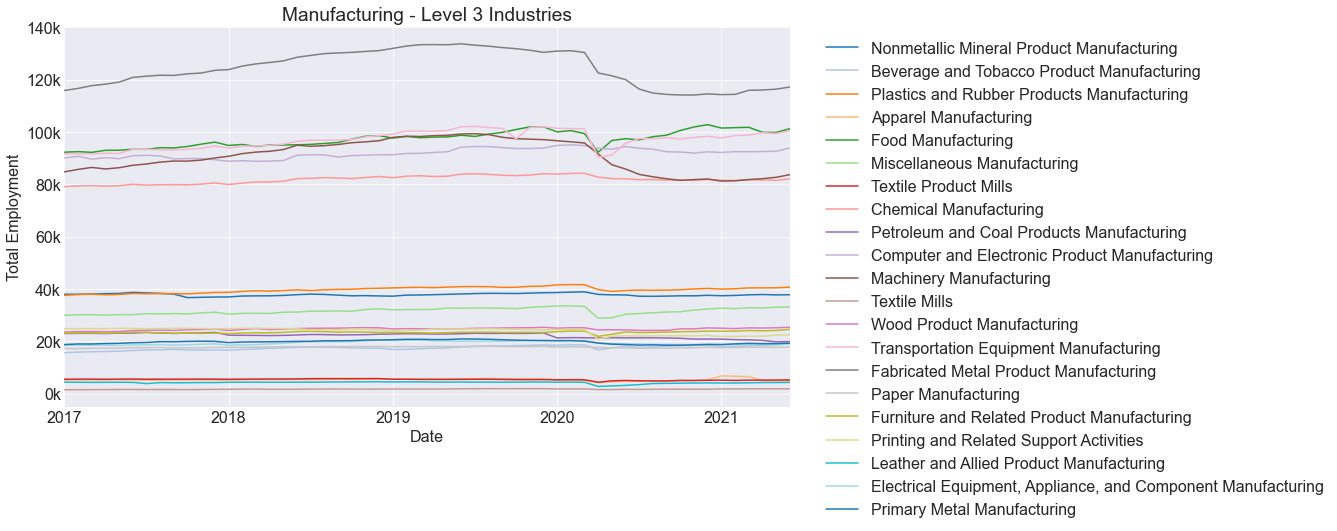

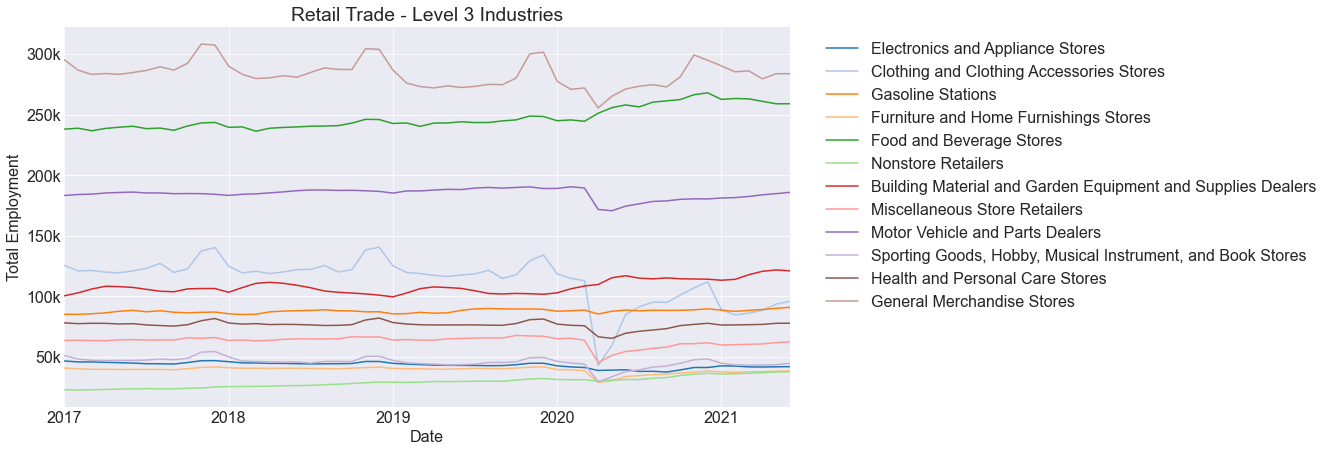

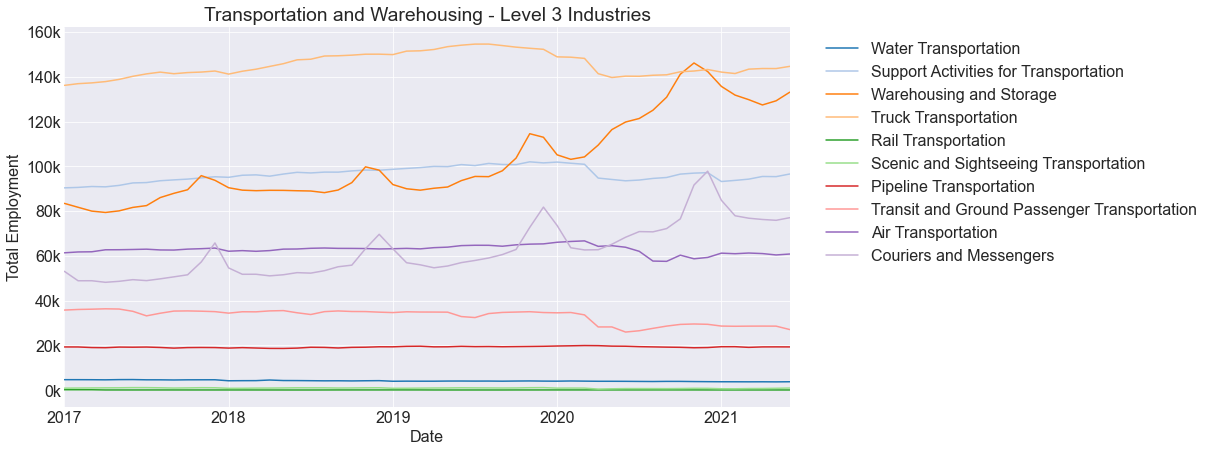

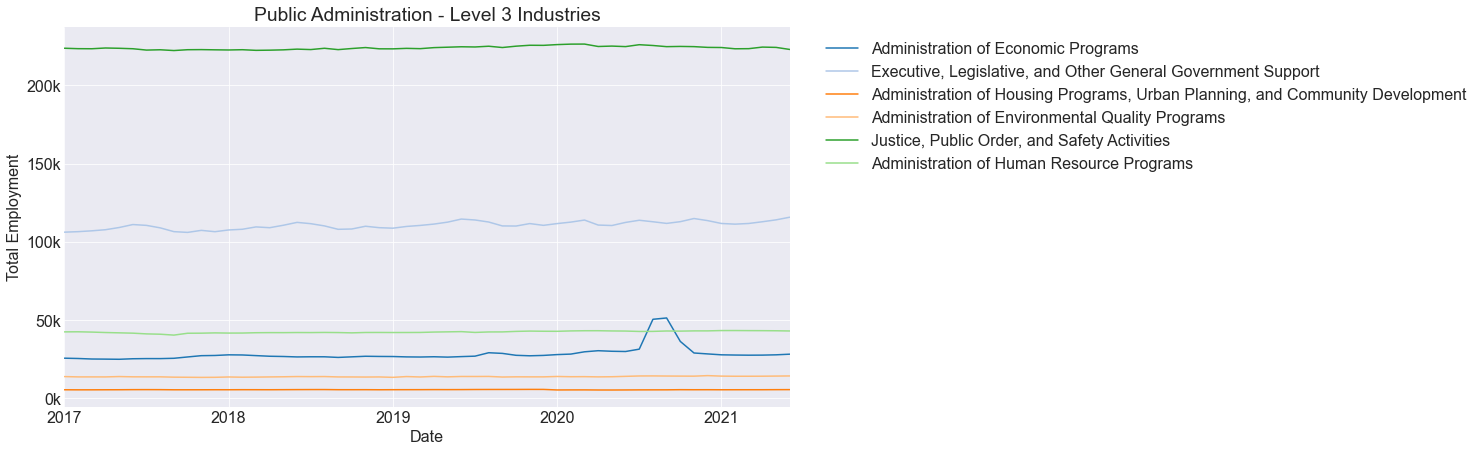

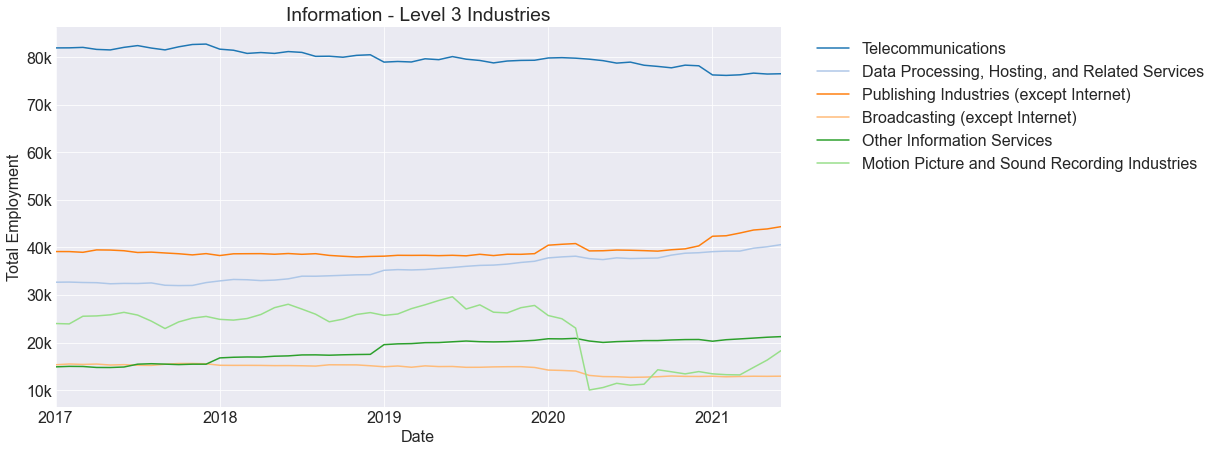

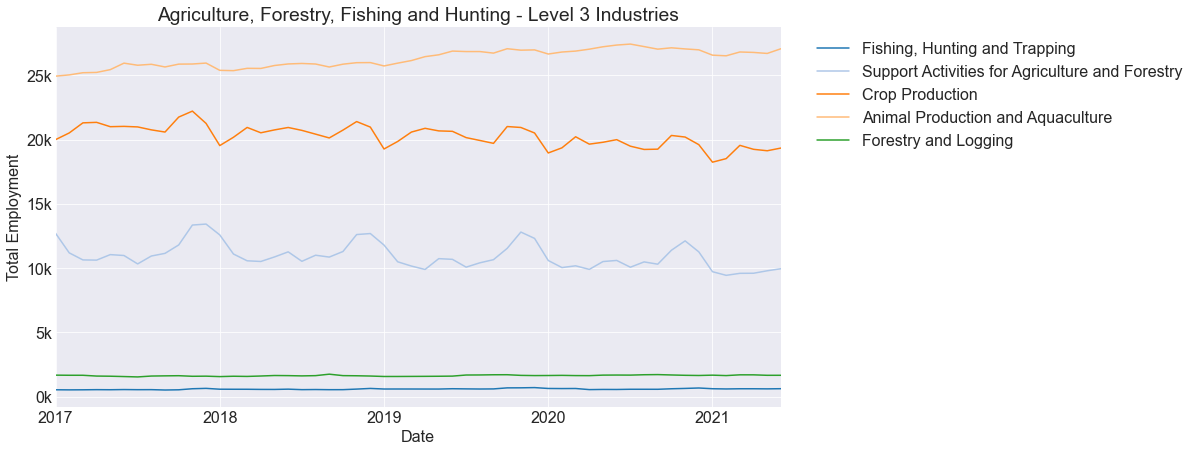

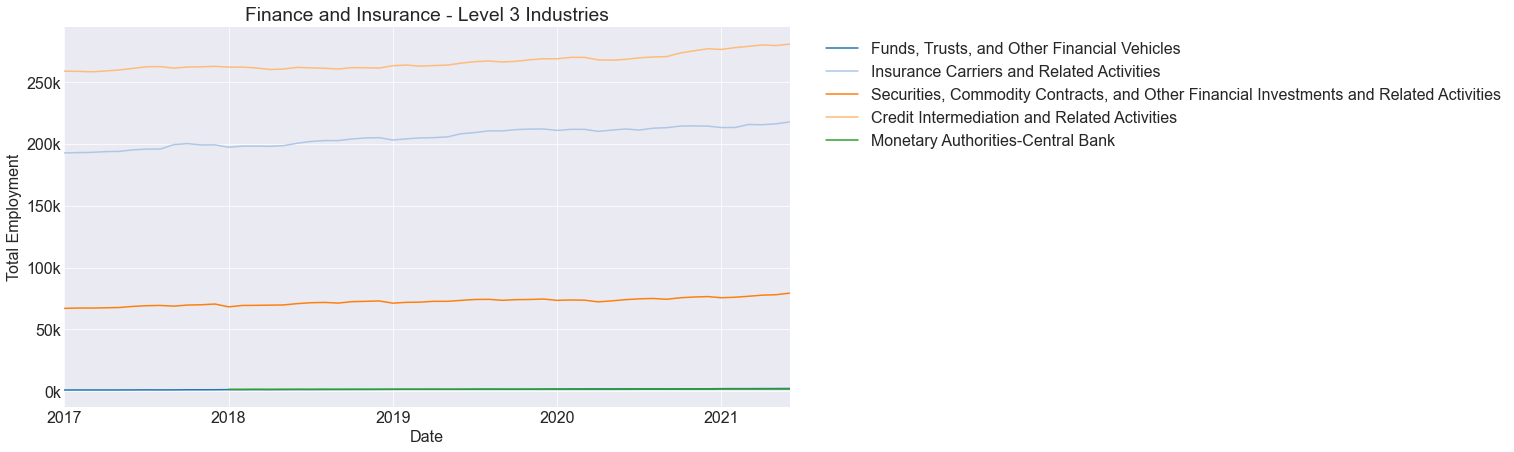

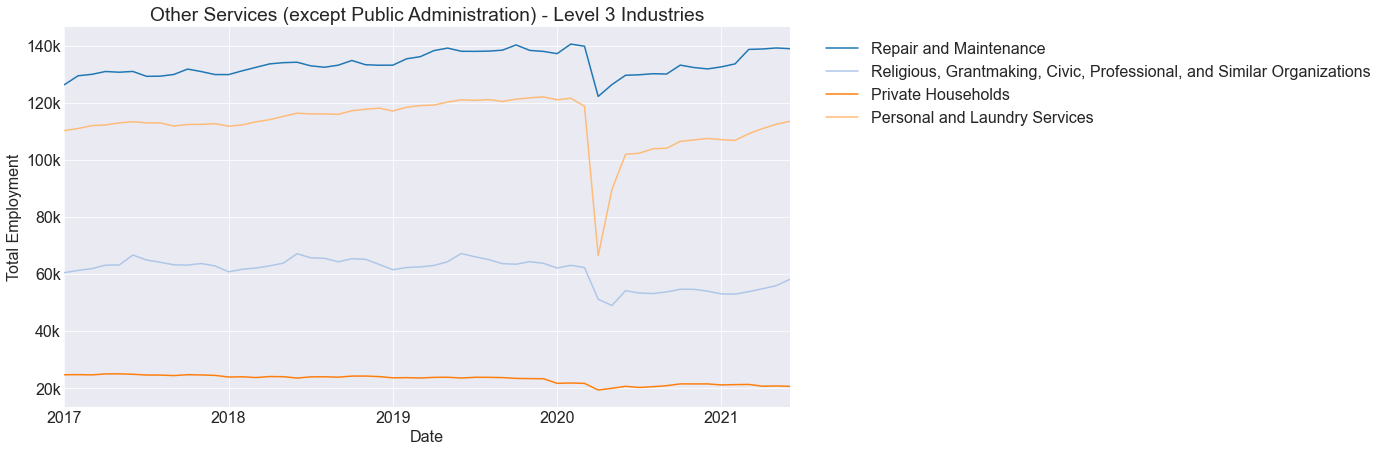

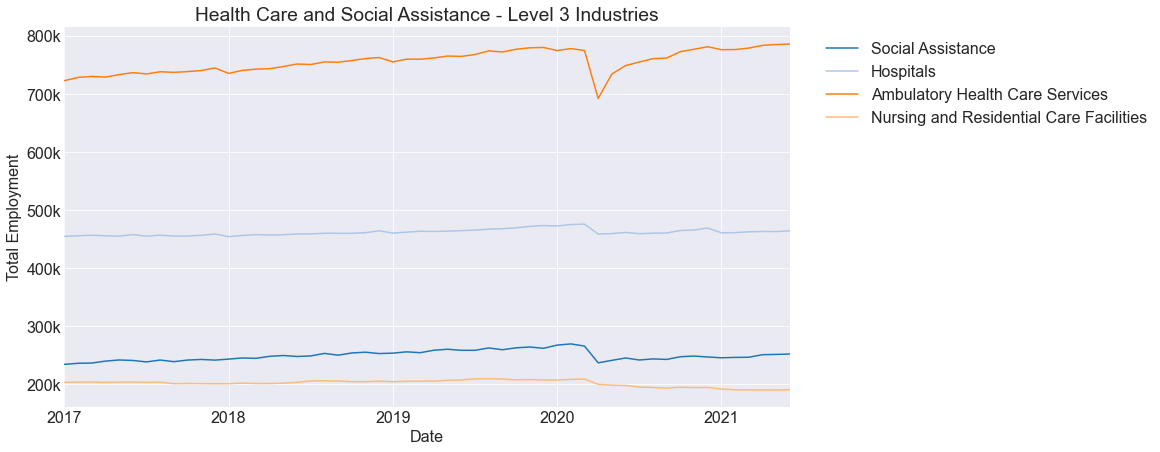

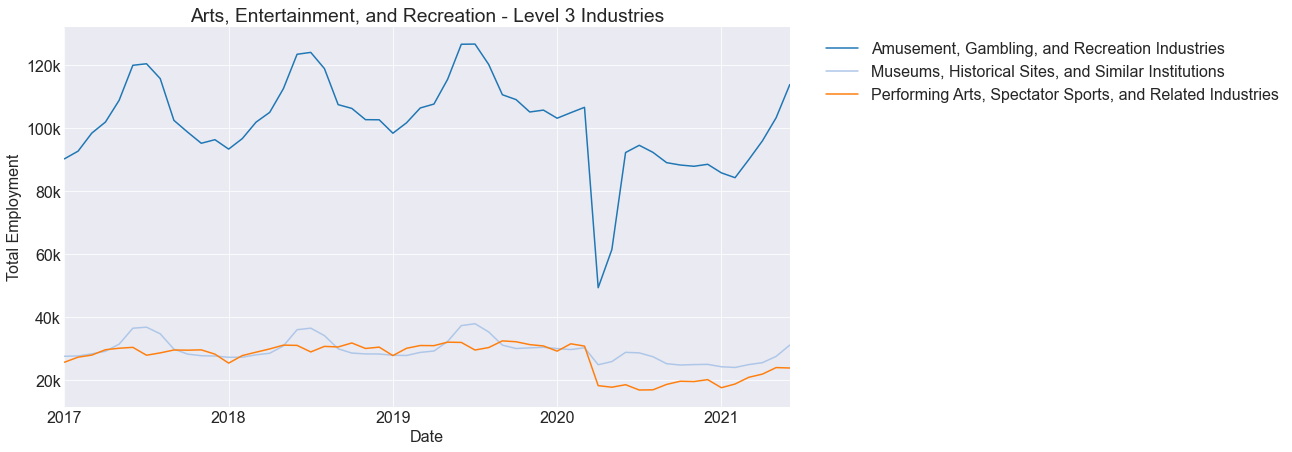

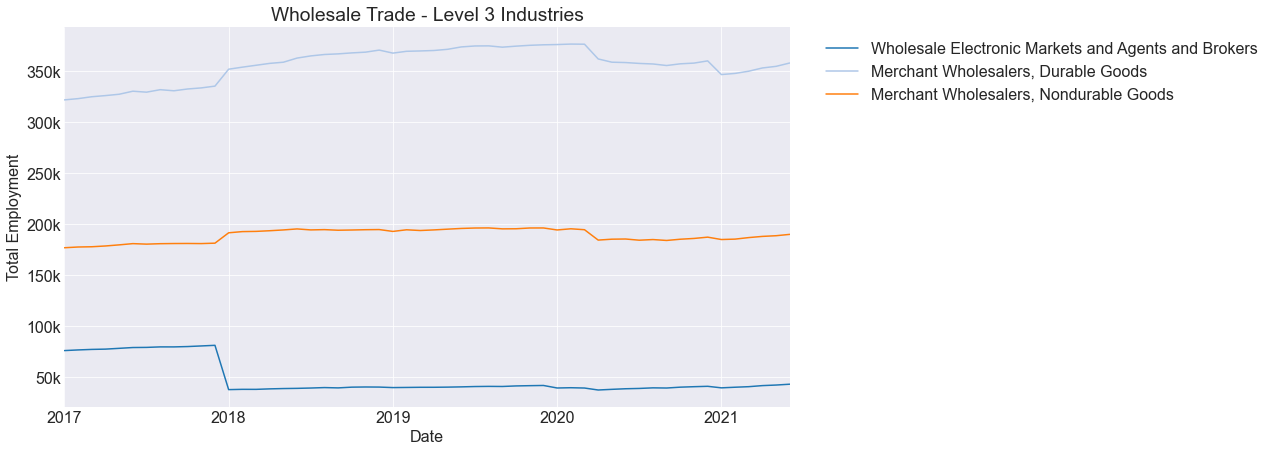

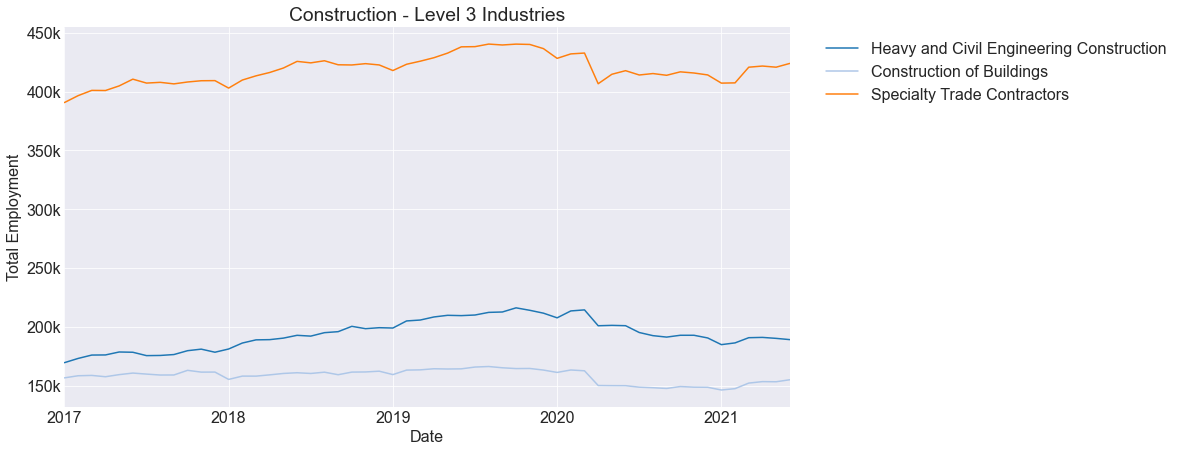

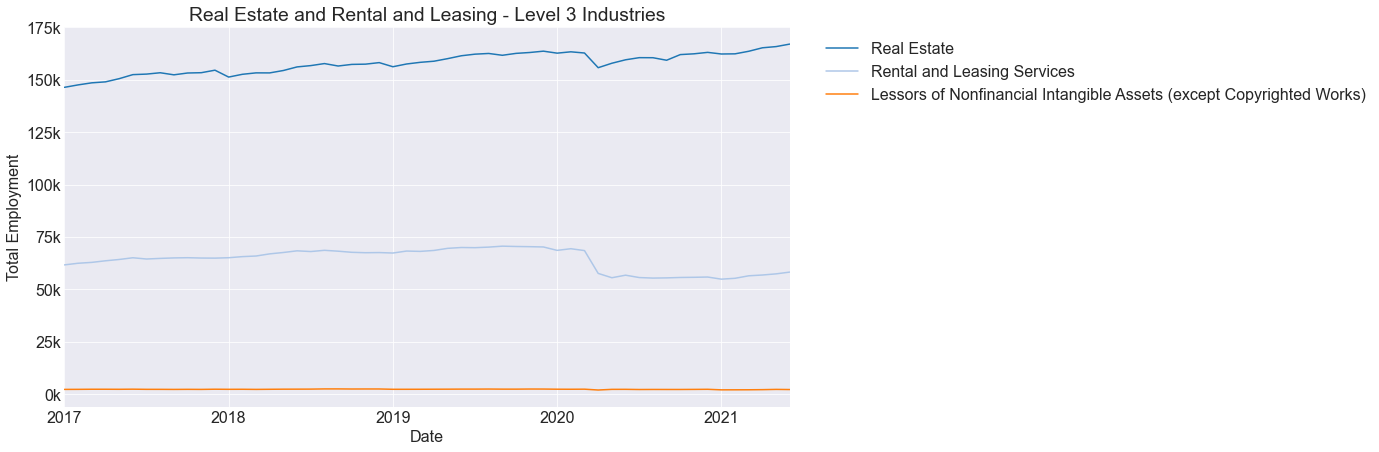

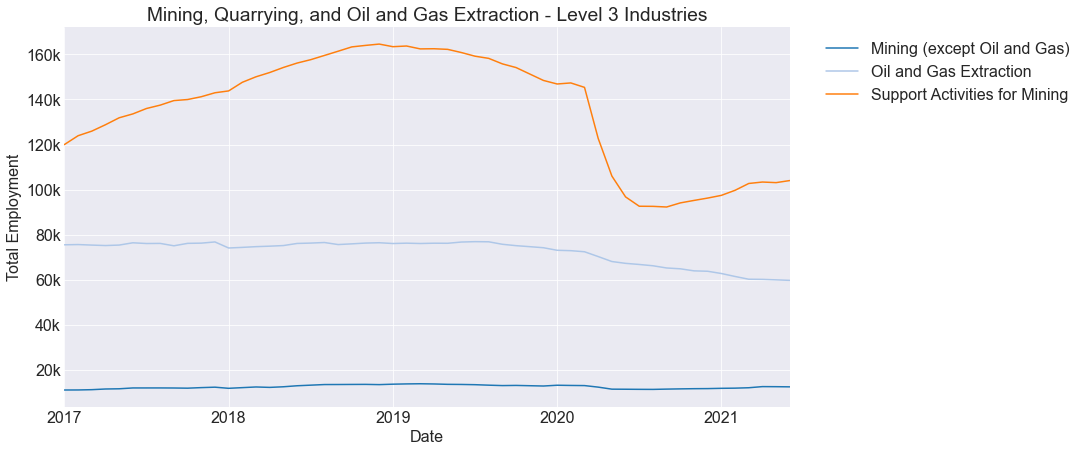

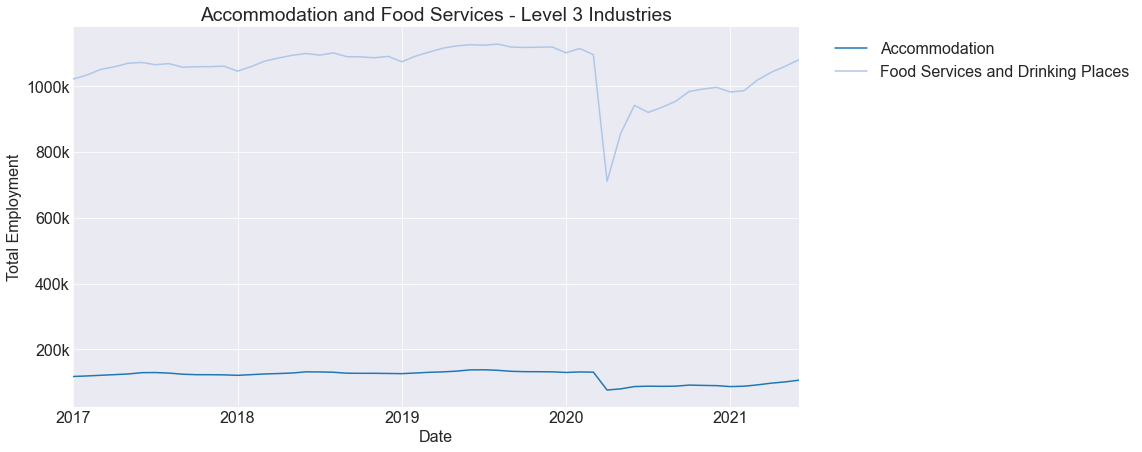

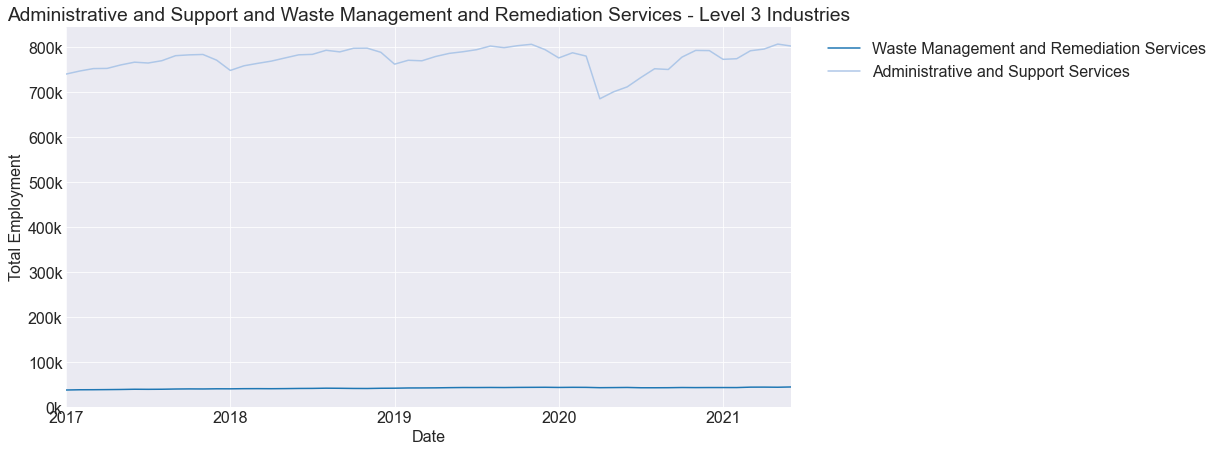

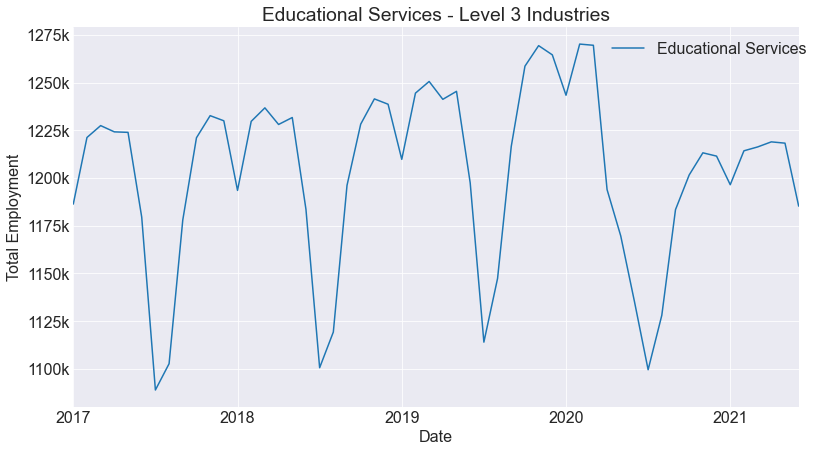

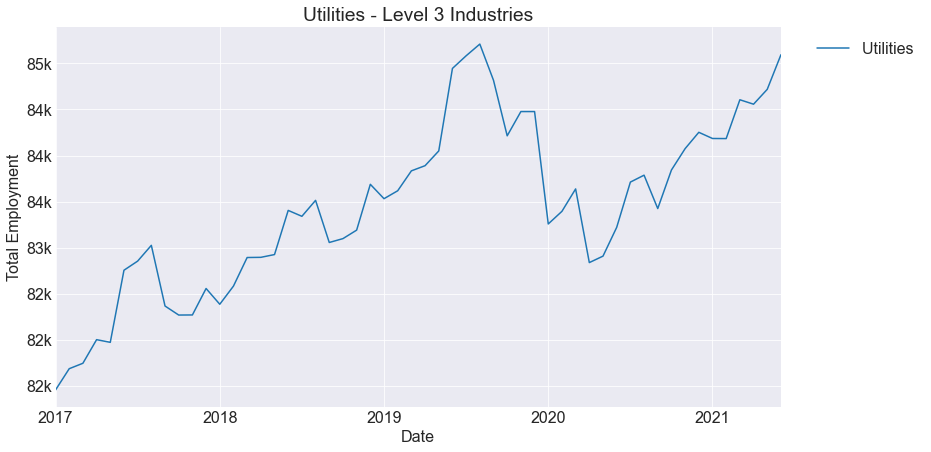

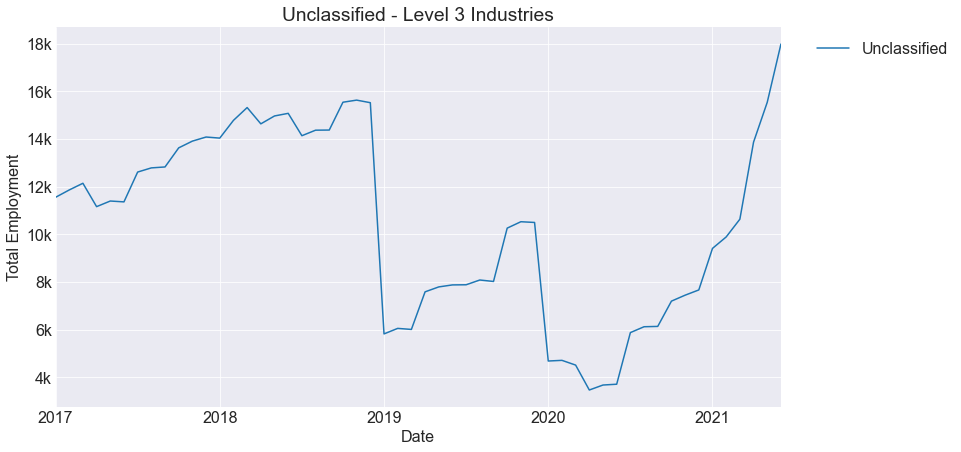

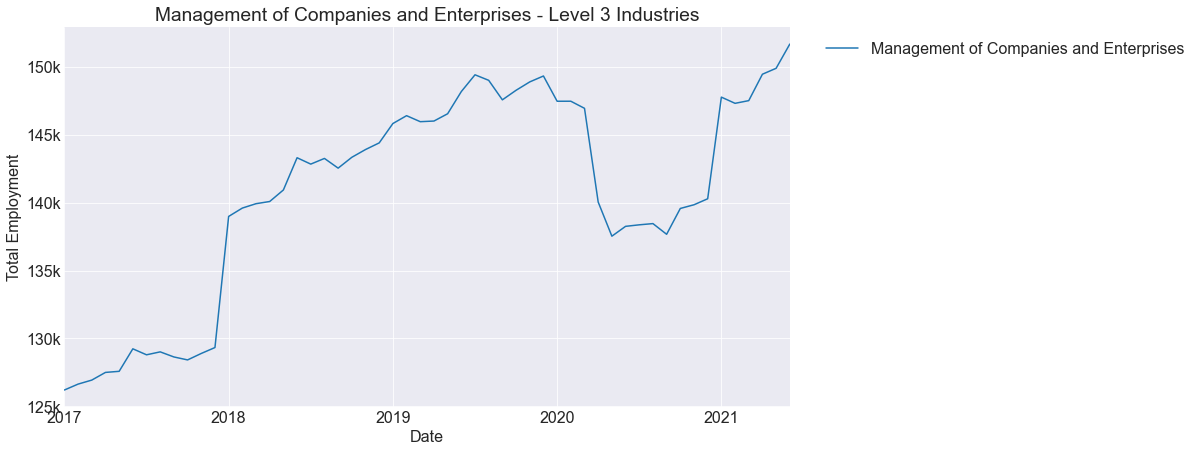

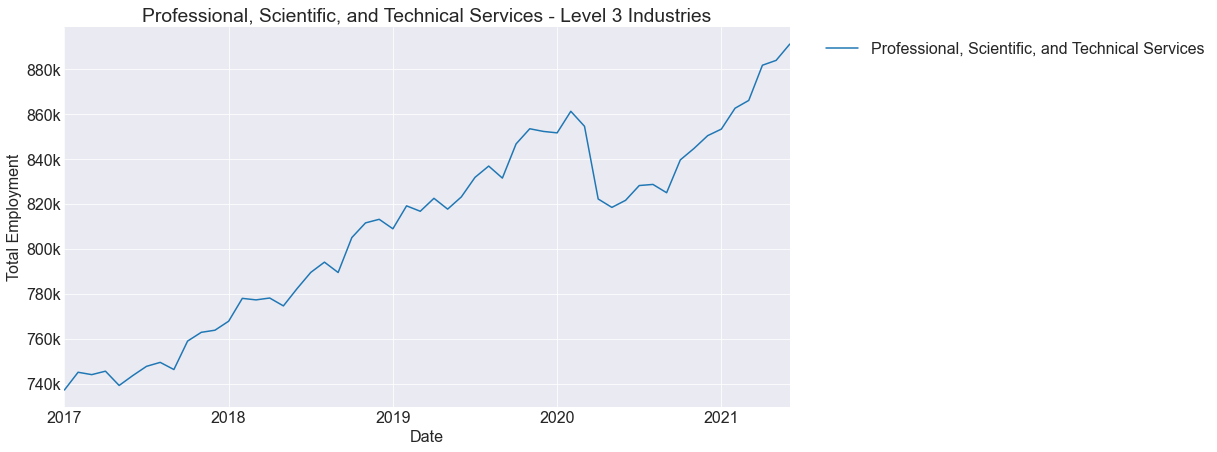

In [30]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

for par in par_ind_list:
    par_df = par_ind_df_dict[par]
    ind_list = par_df.Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = par_df[par_df.Industry == ind]
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

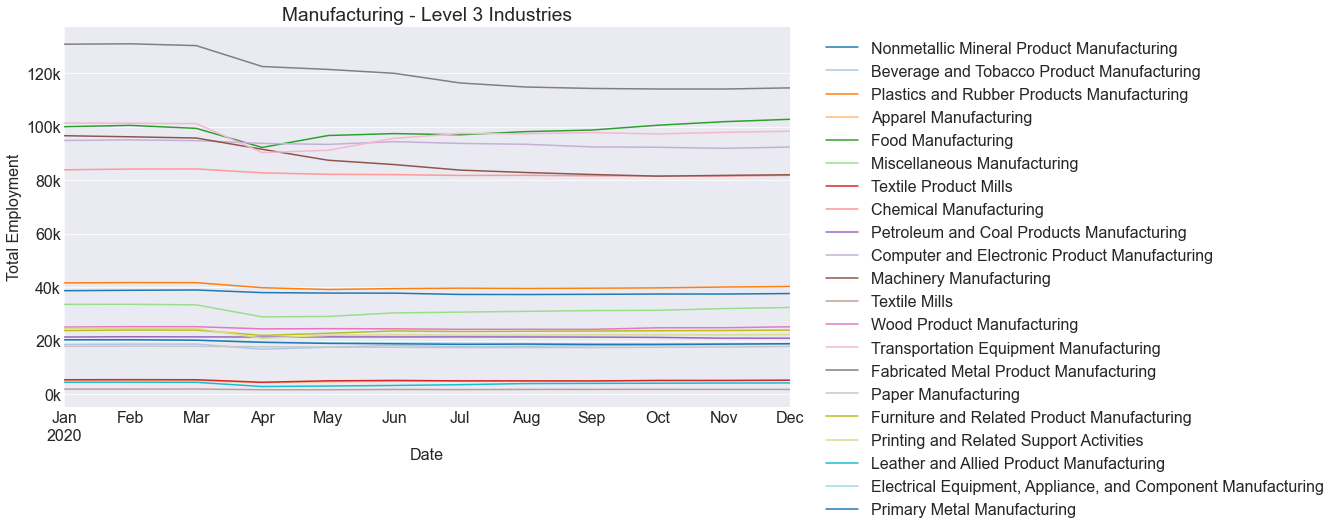

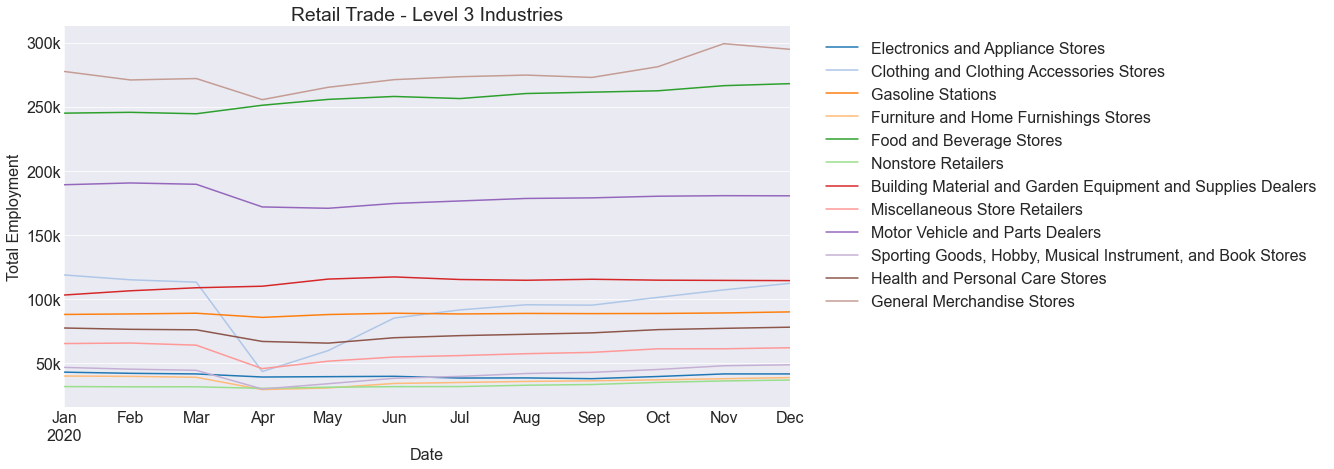

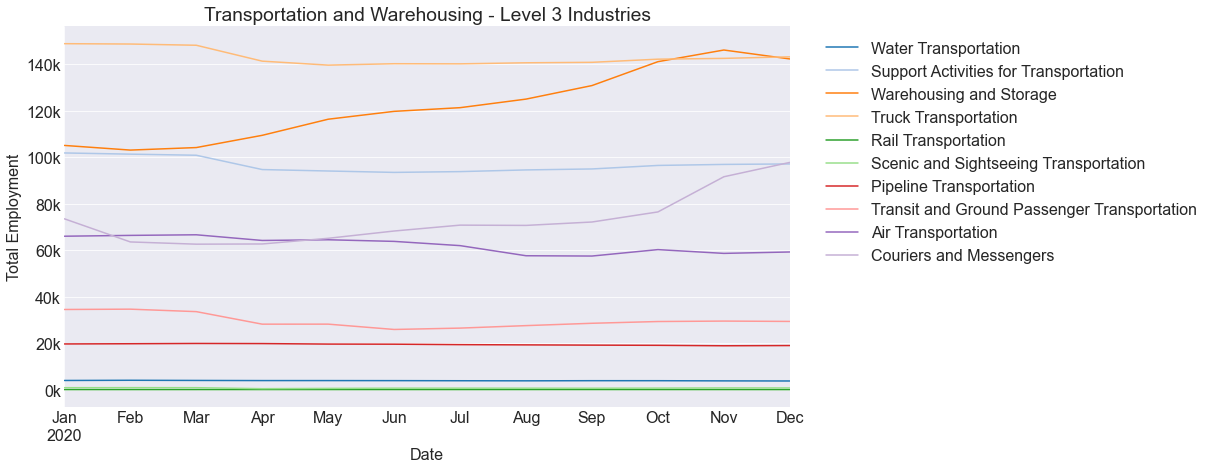

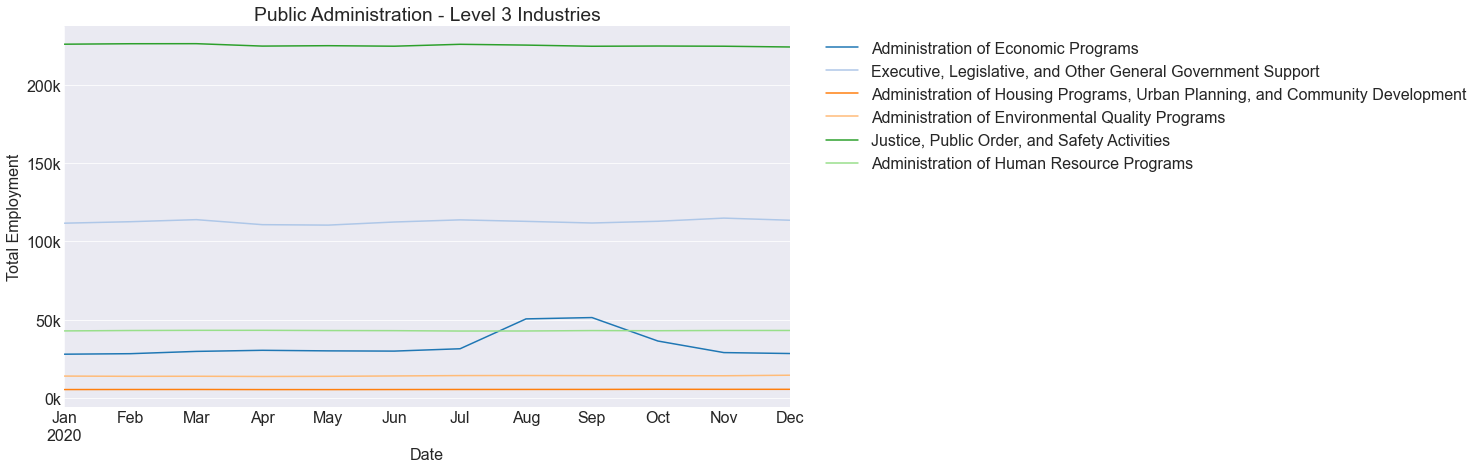

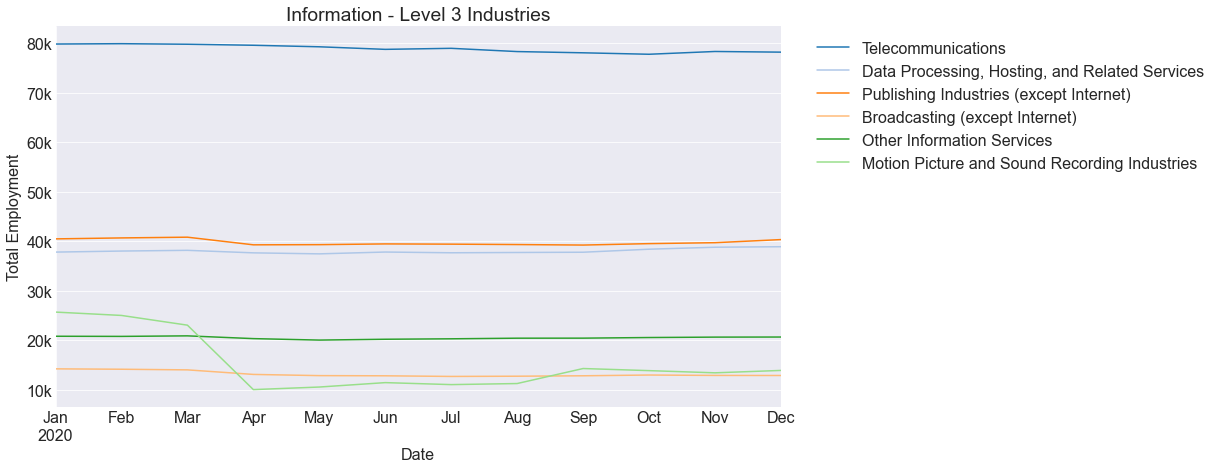

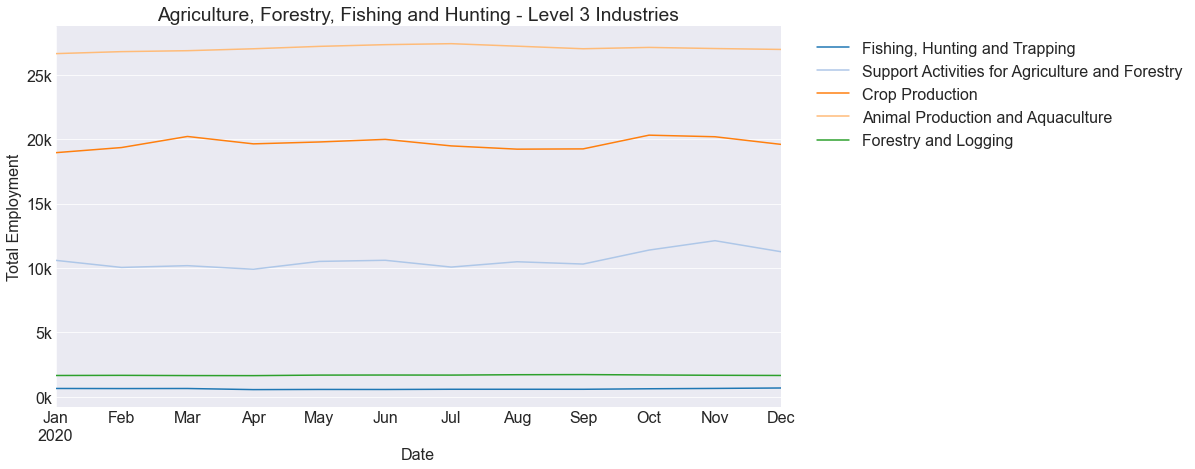

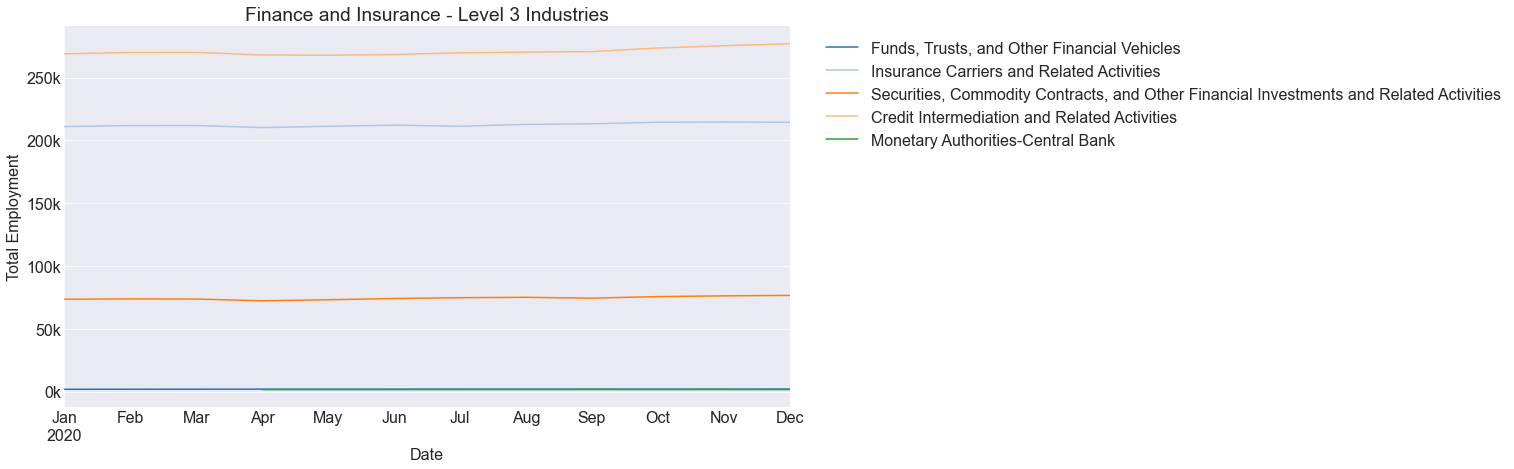

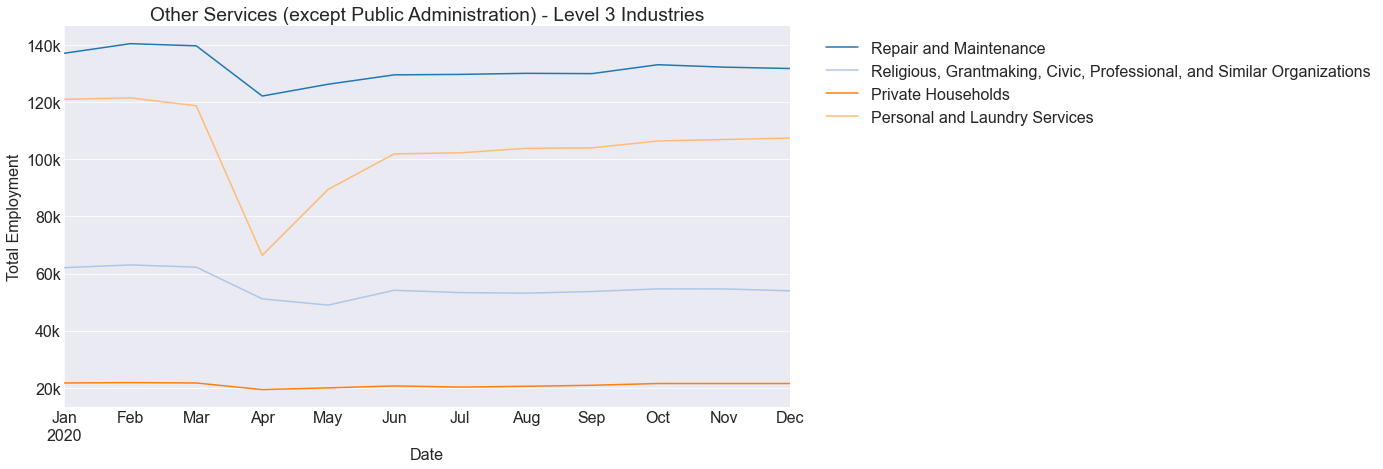

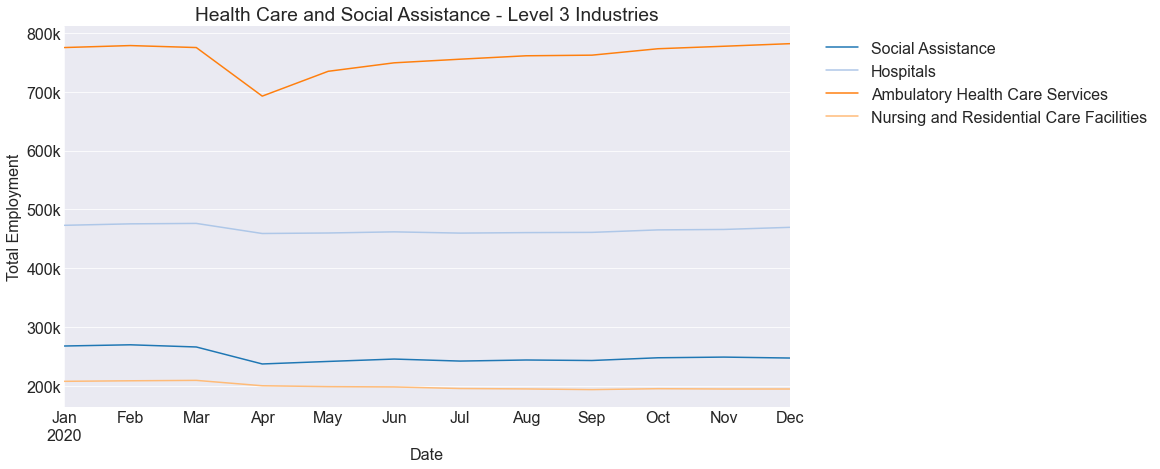

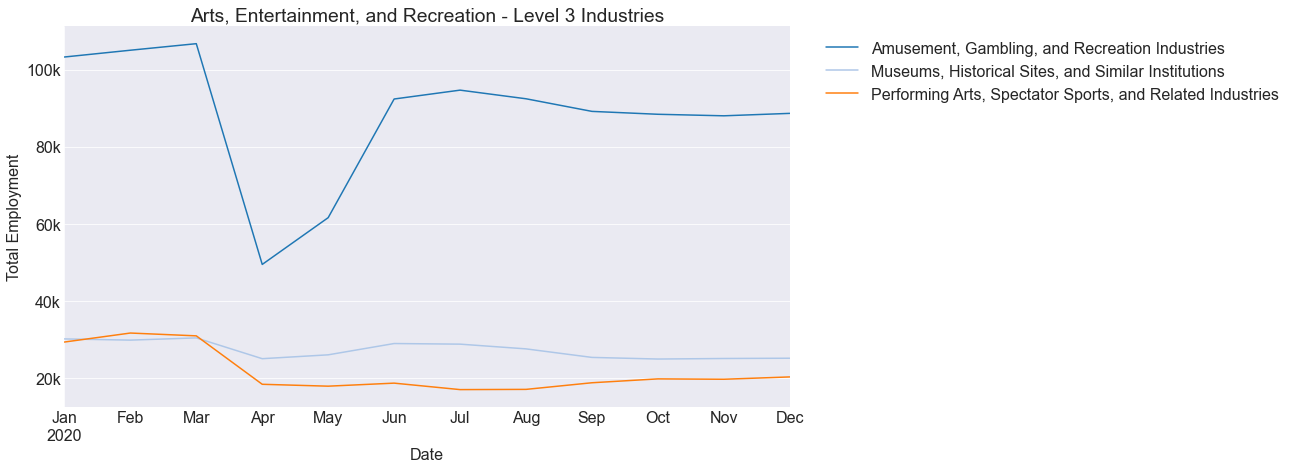

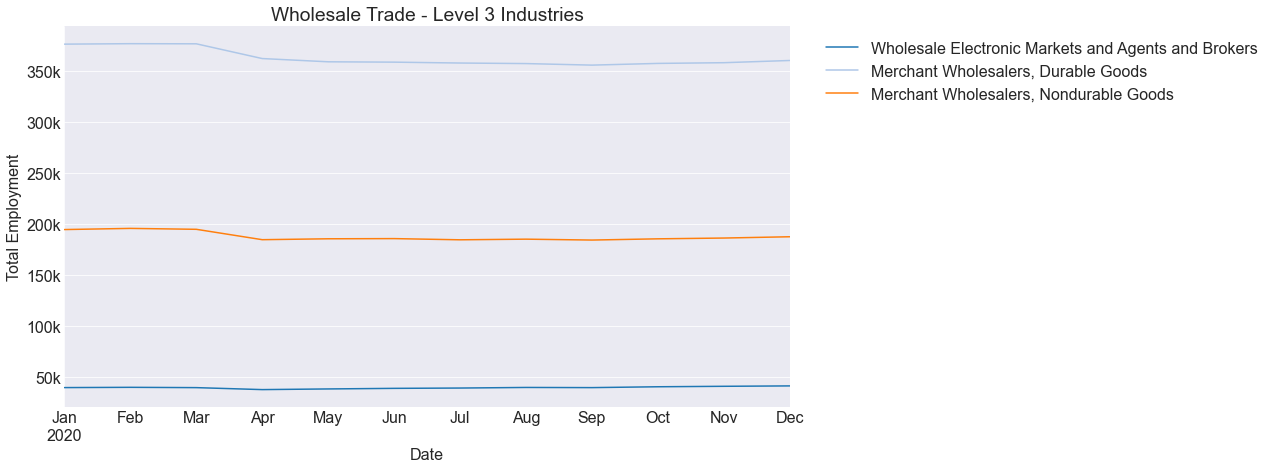

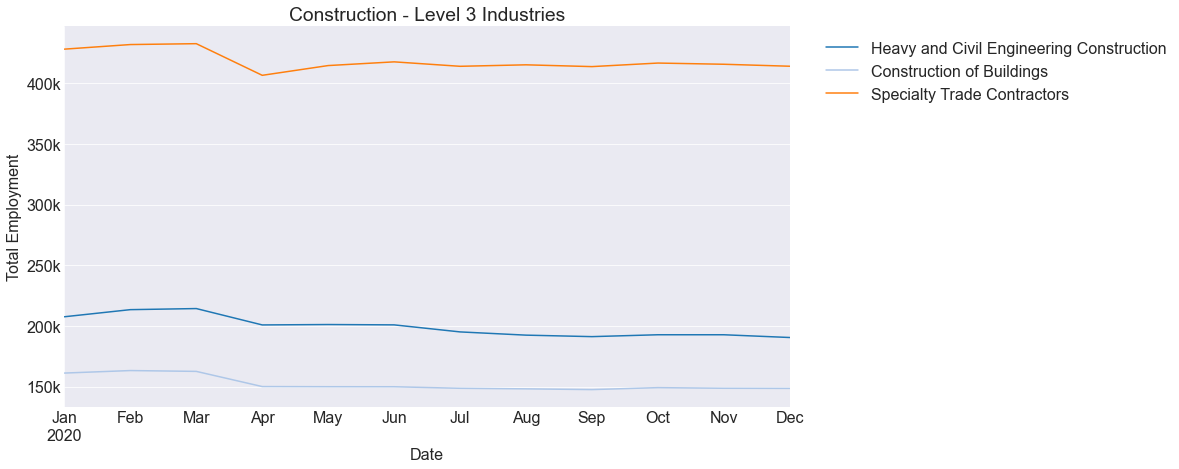

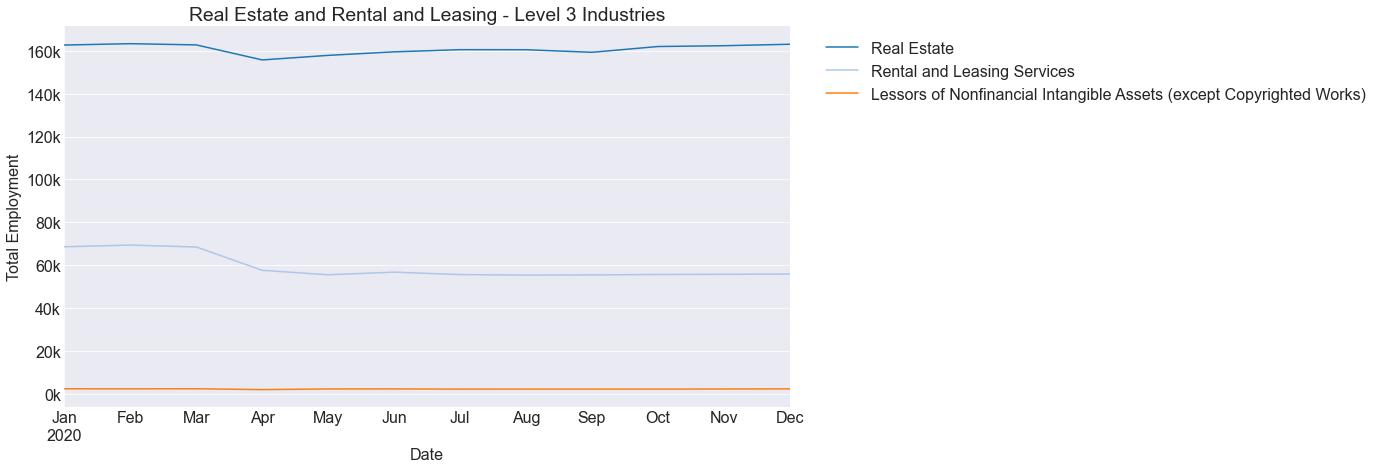

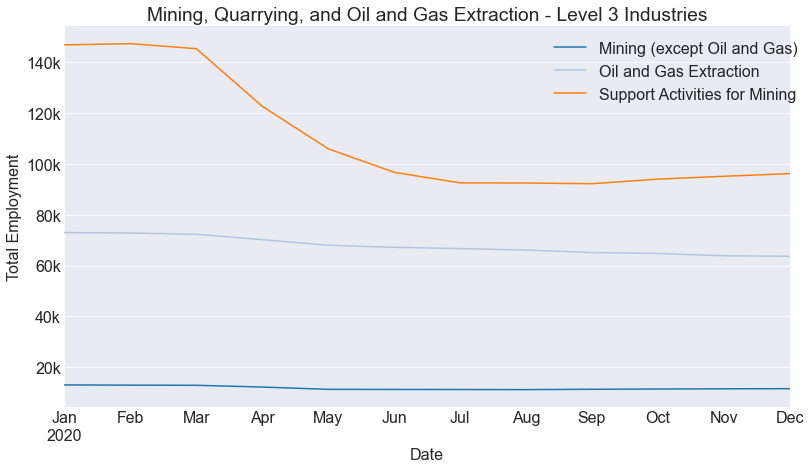

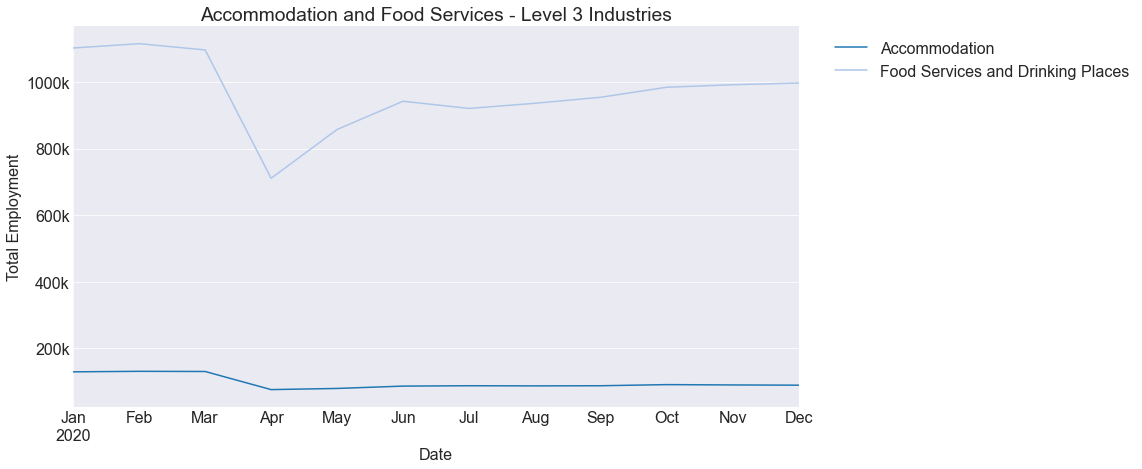

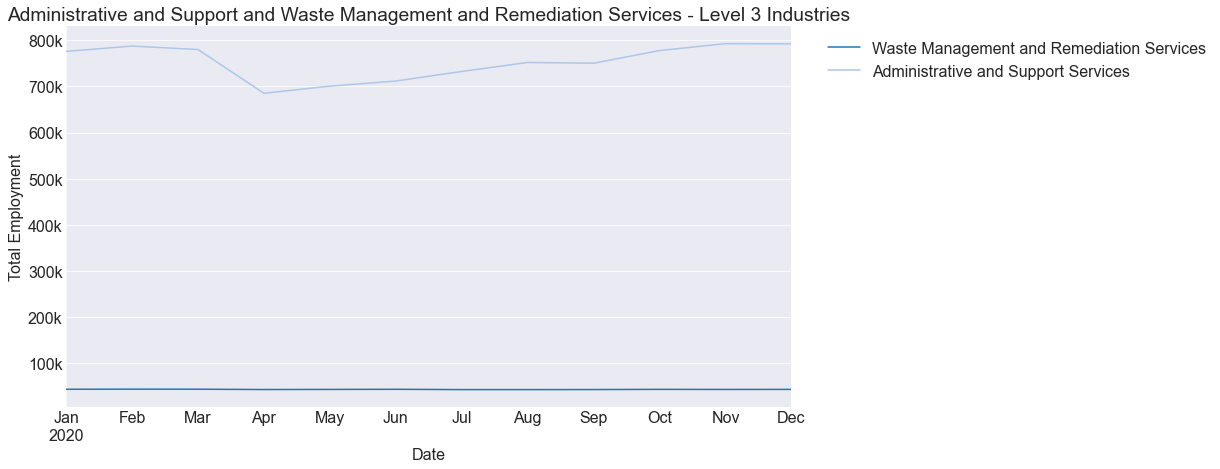

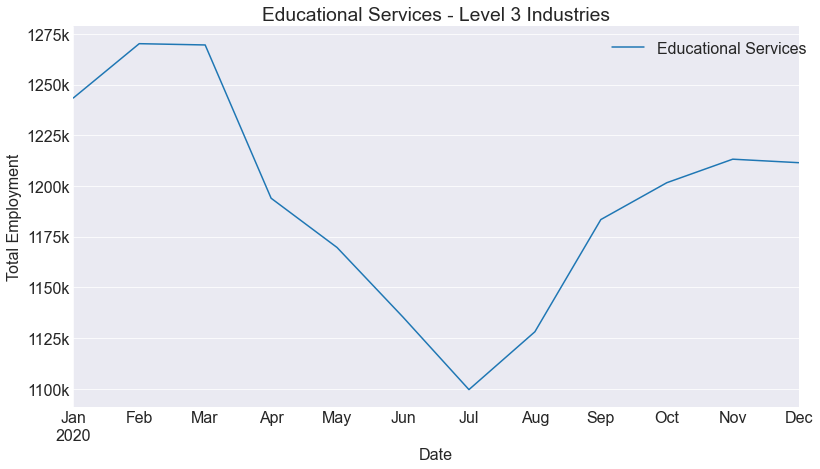

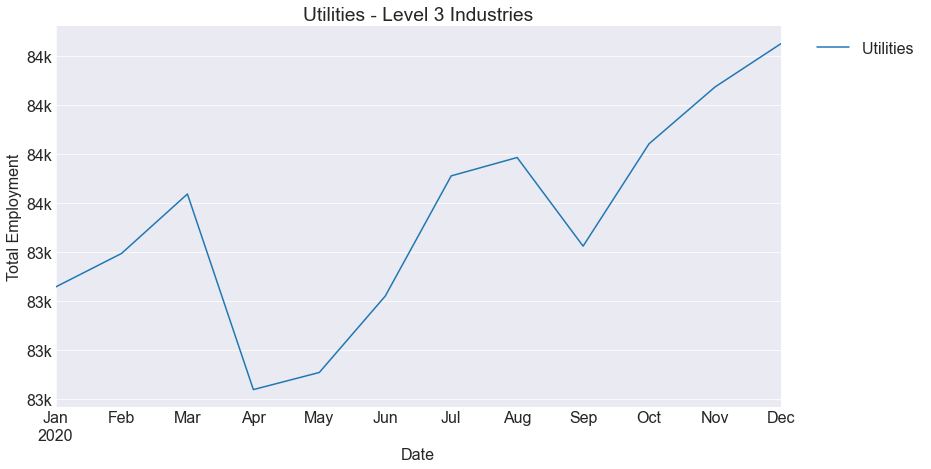

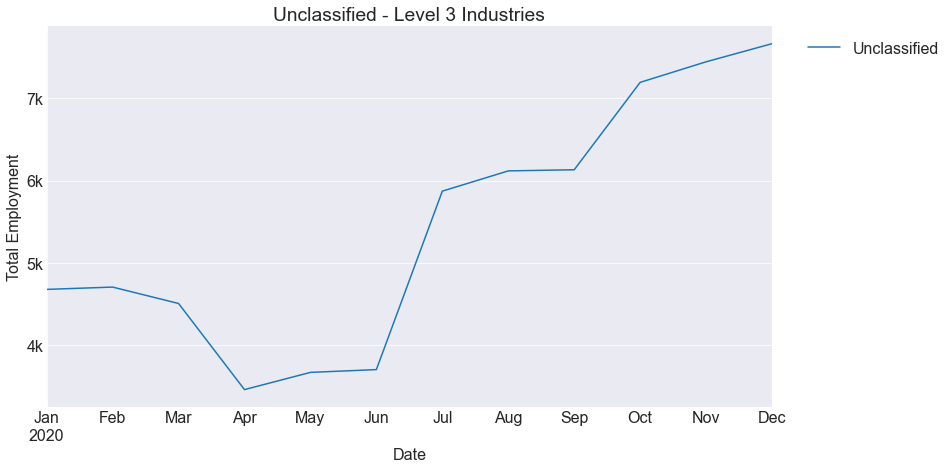

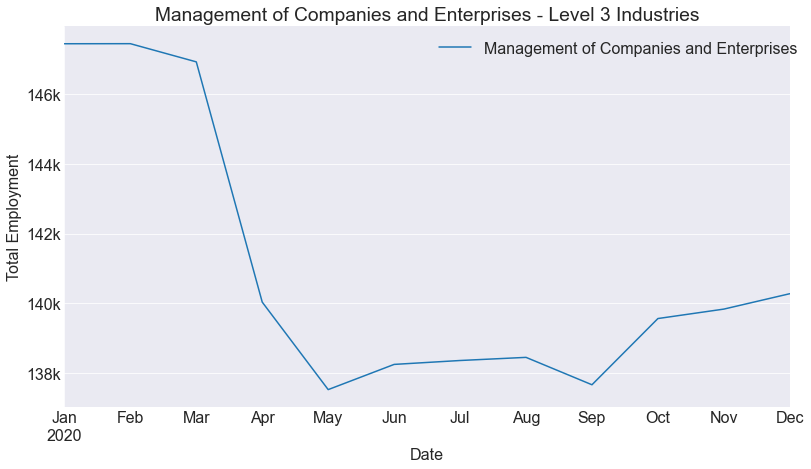

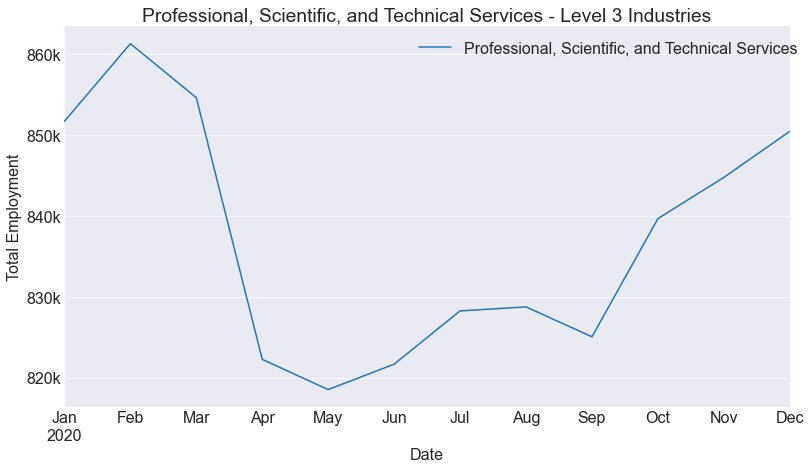

In [31]:
# create a dictionary with subset dfs for each parent industry
par_ind_df_dict = {}
for ind in par_ind_list:
    par_ind_df_dict[ind] = df[df['Parent Industry'] == ind]

for par in par_ind_list:
    par_df = par_ind_df_dict[par]
    ind_list = par_df.Industry.value_counts().index.tolist()
    industry_df_dict = {}
    for ind in ind_list:
        industry_df_dict[ind] = par_df[par_df.Industry == ind]
    for ind in ind_list:
        industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment']['2020'].sort_index().plot(label=ind)
    plt.gca().set(ylabel = 'Total Employment', title=f'{par} - Level 3 Industries')
    plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.legend(bbox_to_anchor= (1.03,1))
    plt.show()

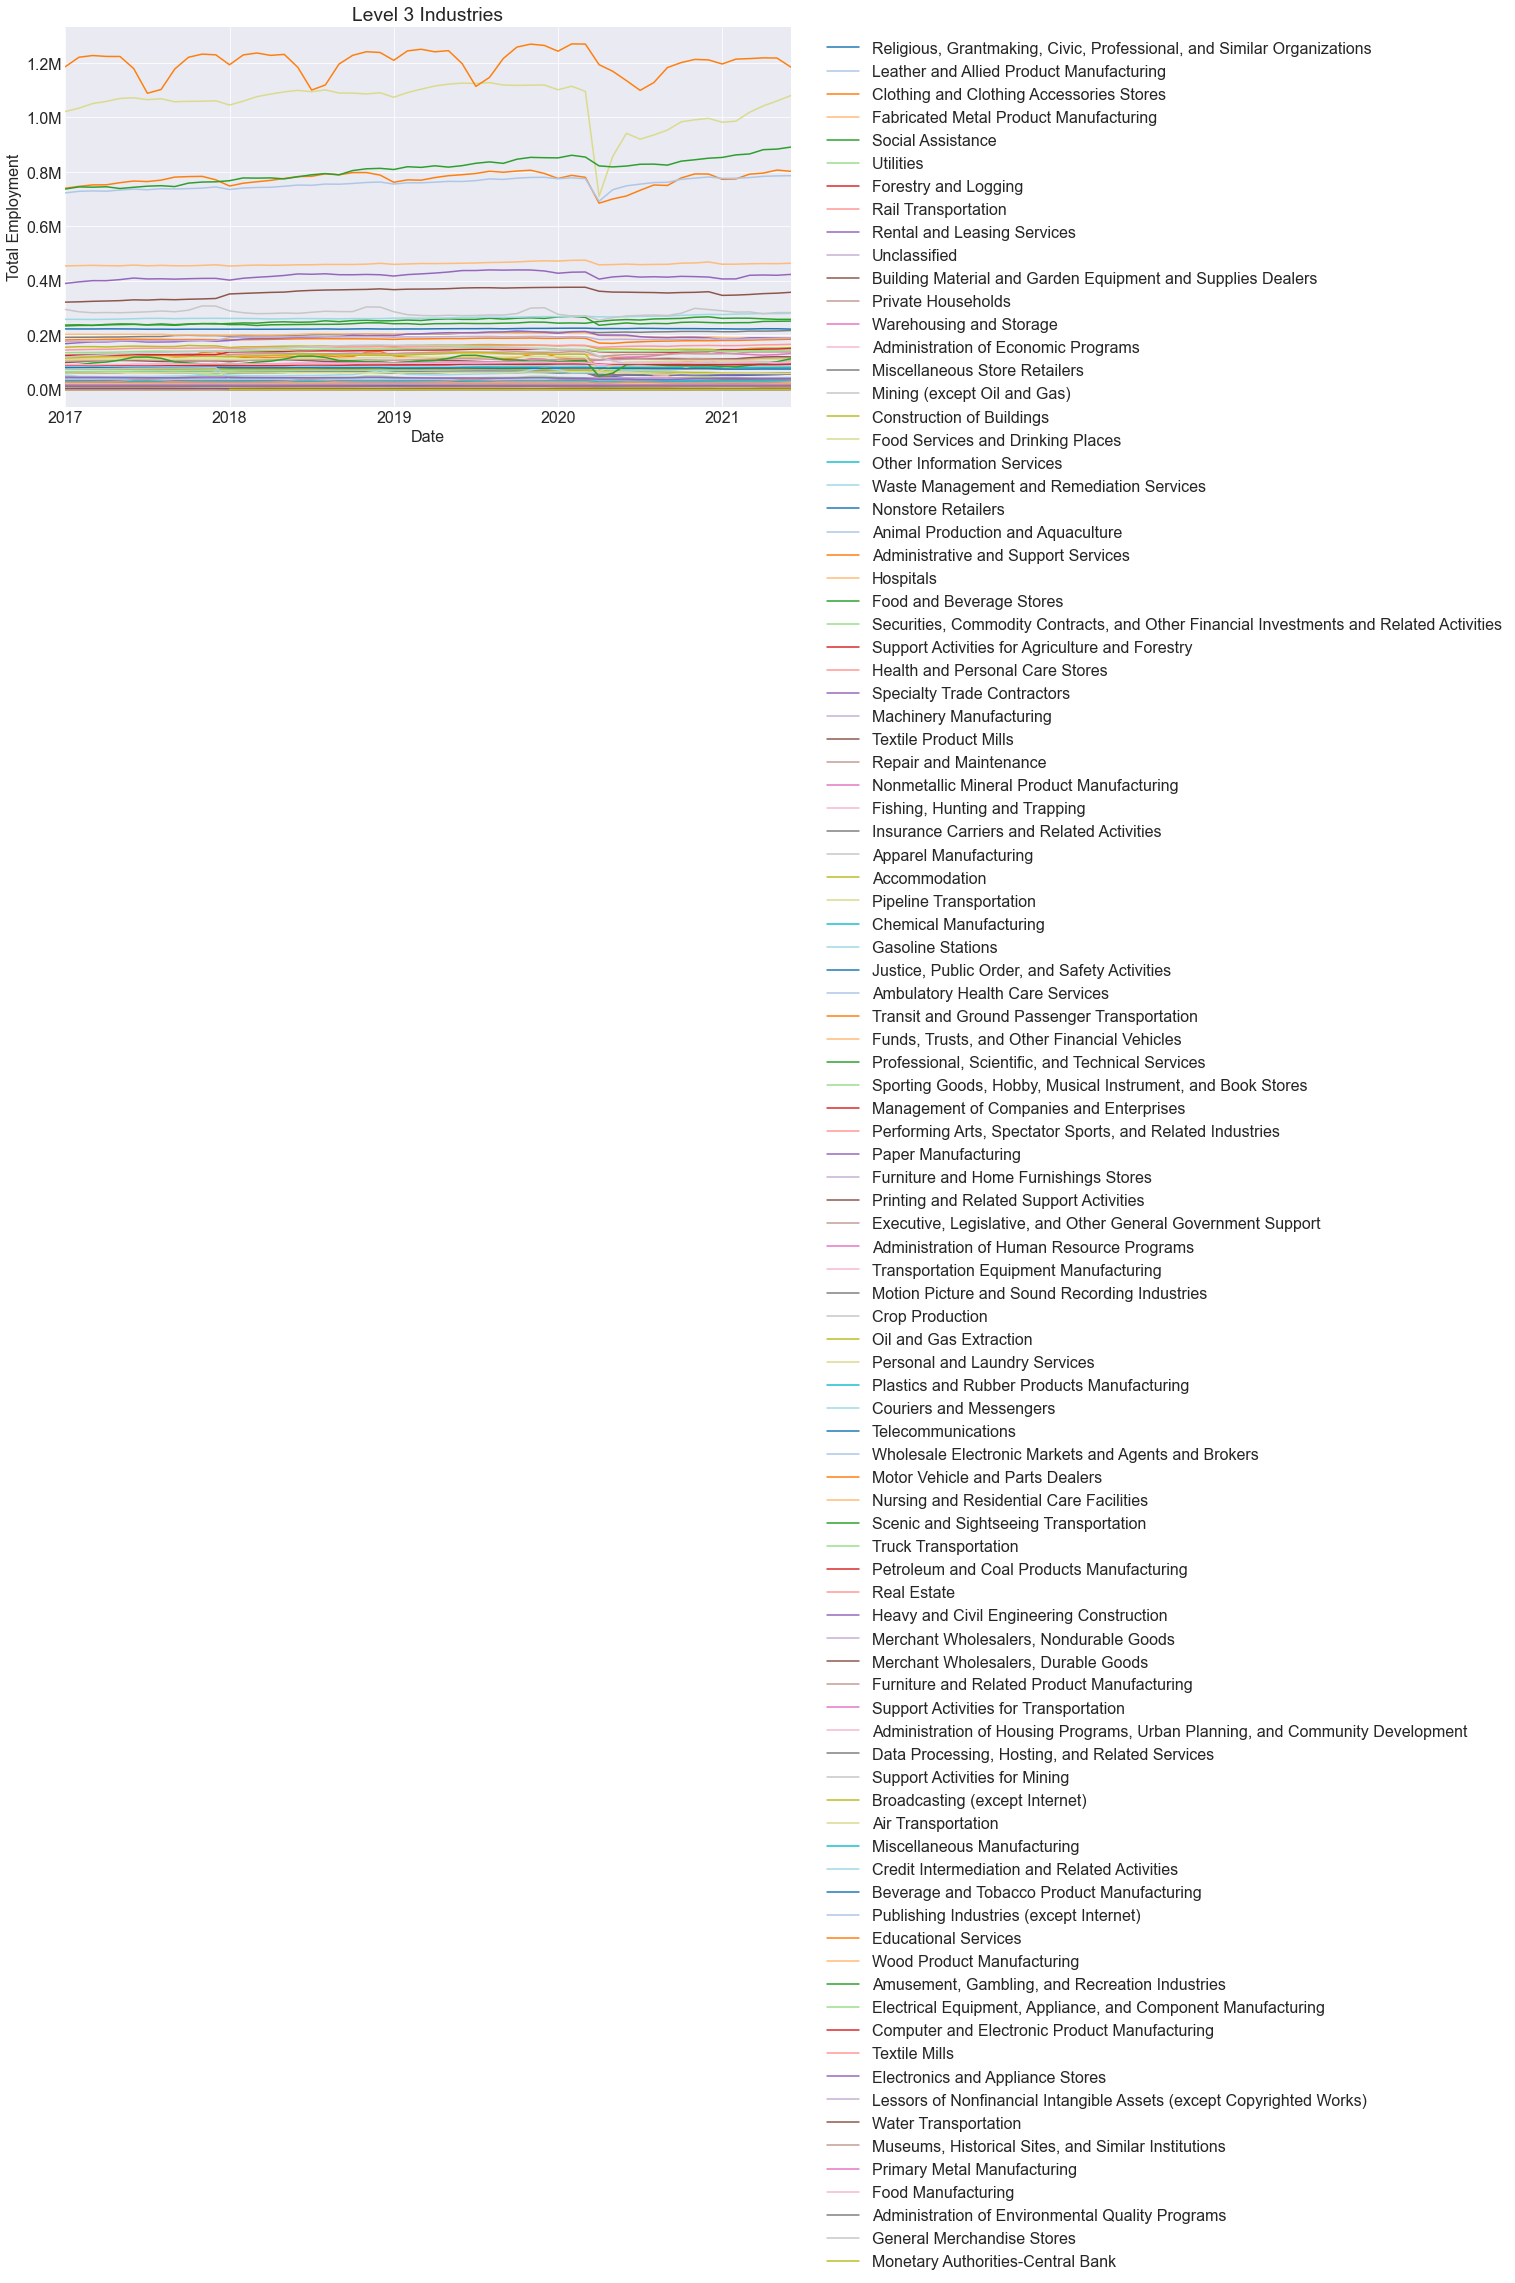

In [32]:
# plot for all industries
ind_list = df.Industry.value_counts().index.tolist()
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind]
for ind in ind_list:
    industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index().plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 3 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

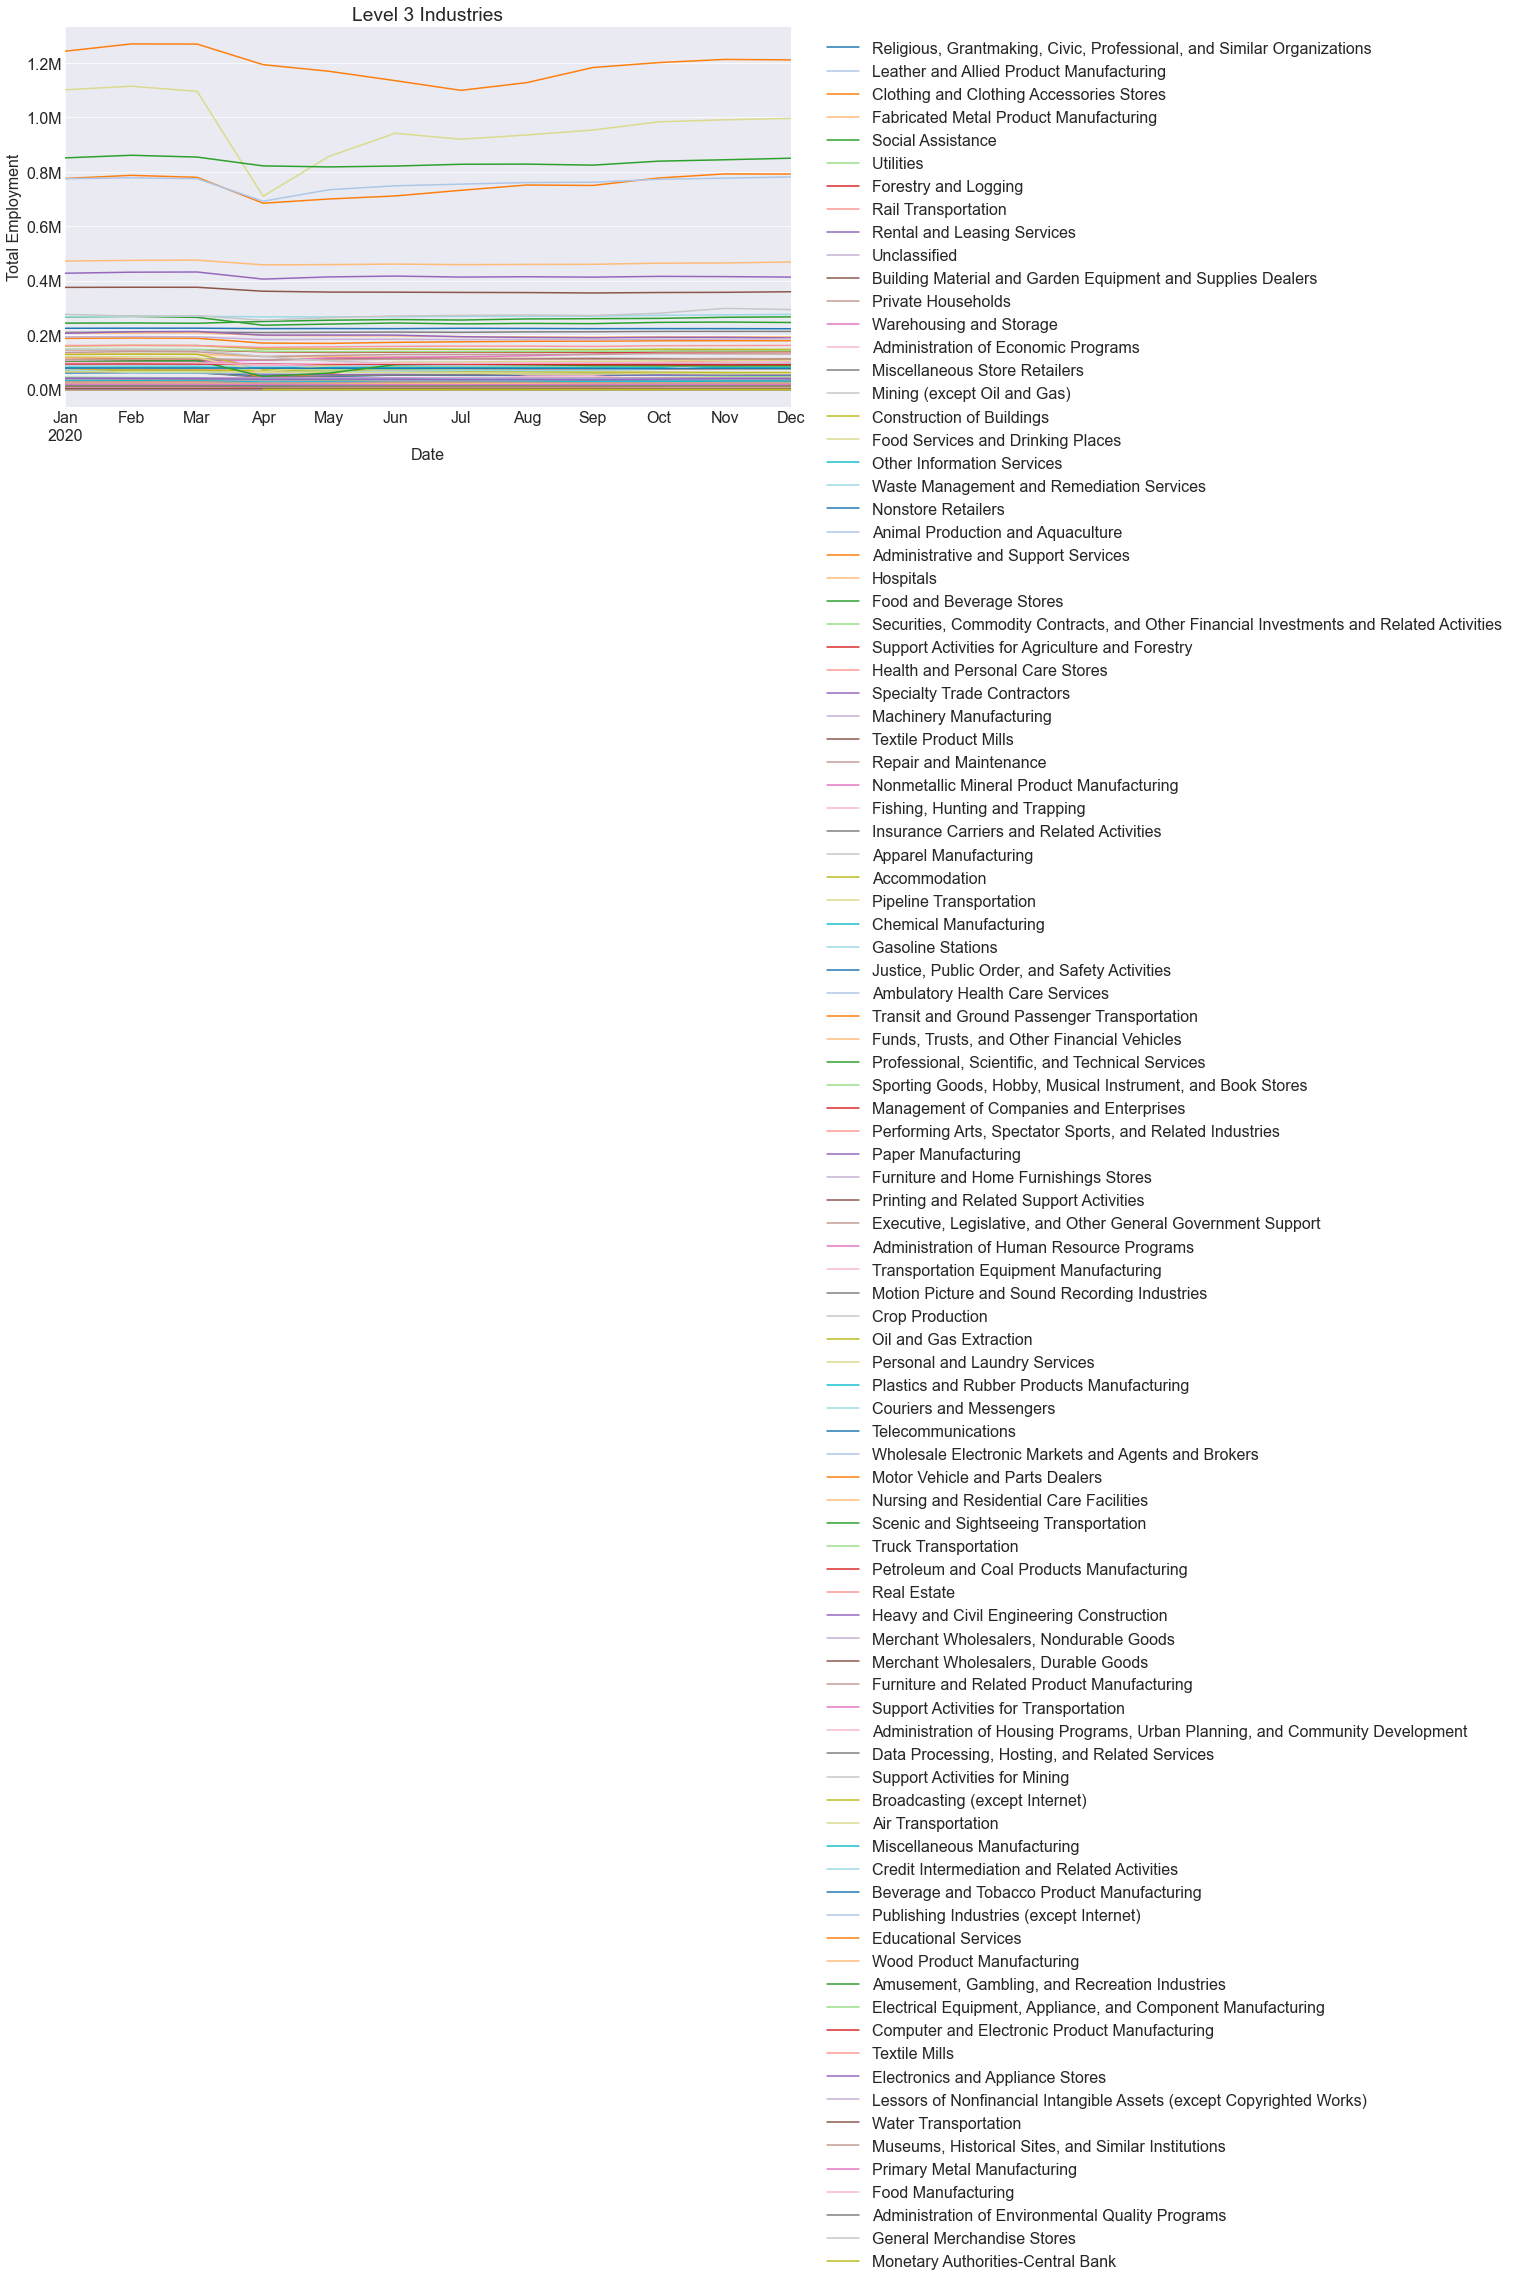

In [33]:
# plot for all industries 2020
ind_list = df.Industry.value_counts().index.tolist()
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind]
for ind in ind_list:
    industry_df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment']['2020'].sort_index().plot(label=ind)
plt.gca().set(ylabel = 'Total Employment', title='Level 3 Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

In [34]:
# create a dictionary with all dfs for each industry for year 2020
ind_list = df.Industry.value_counts().index.tolist()
ind_list[-1]

'Monetary Authorities-Central Bank'

In [35]:
ind_list.pop(-1)

'Monetary Authorities-Central Bank'

In [36]:
len(ind_list)

96

In [37]:
industry_df_dict = {}
for ind in ind_list:
    industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index()['2020']

In [38]:
industry_df_dict['Plastics and Rubber Products Manufacturing']

Date
2020-01-01    41576
2020-02-01    41694
2020-03-01    41663
2020-04-01    39774
2020-05-01    39098
2020-06-01    39448
2020-07-01    39605
2020-08-01    39508
2020-09-01    39591
2020-10-01    39712
2020-11-01    40020
2020-12-01    40227
Name: Total Employment, dtype: int64

In [39]:
apr = industry_df_dict['Plastics and Rubber Products Manufacturing']['2020-04'][0]

In [40]:
mar = industry_df_dict['Plastics and Rubber Products Manufacturing']['2020-03'][0]

In [41]:
(apr / mar) * 100

95.46600100808871

In [42]:
len(industry_df_dict)

96

In [43]:
industry_df_dict['Plastics and Rubber Products Manufacturing'].std()

938.2133245825505

Need to figure out how to create a new df with rows for each industry (97) and columns for each statistical characteristic

In [44]:
# write a function that takes in a series and returns a dictionary with all the characteristic values with associated keys (column names)
def characterize_series(series):
    pcnt_decrease = ((s['2020-03'][0] - s['2020-04'][0]) / s['2020-03'][0]) * 100
    recovery_slope = (s['2020-06'][0] - s['2020-04'][0]) / 2 # need to normalize this?
    mean = s.mean()
    std = s.std()
    rec_slope_norm = recovery_slope / mean
    cov = mean / std
    characteristic_dict = {
        'pcnt_decrease' : pcnt_decrease,
        'recovery_slope' : recovery_slope,
        'mean' : mean,
        'standard_dev' : std,
        'recovery_slope_normalized' : rec_slope_norm,
        'cov' : cov
    }
    return characteristic_dict

In [45]:
# create an empty characteristics list (list of dictionaries to convert to df)
characteristics = []

In [46]:
# Use dictionary comprehension that runs through each entry in industry_df_dict and appends dictionary to char list (or for loop)
for ind in ind_list:
    s = industry_df_dict[ind]
    characteristics.append(characterize_series(s))
    #print(len(s))

In [49]:
# convert characteristics list into df
char_df = pd.DataFrame(characteristics, index=ind_list)
char_df.sort_values(by='pcnt_decrease', ascending=True).head(10)

pcnt_decrease  \
Rail Transportation                                     -6.666667   
Warehousing and Storage                                 -5.055032   
Funds, Trusts, and Other Financial Vehicles             -2.905441   
Food and Beverage Stores                                -2.721895   
Administration of Economic Programs                     -2.361331   
Building Material and Garden Equipment and Supp...      -1.102687   
Animal Production and Aquaculture                       -0.554357   
Couriers and Messengers                                 -0.143687   
Administration of Human Resource Programs               -0.027782   
Pipeline Transportation                                  0.246120   

                                                    recovery_slope  \
Rail Transportation                                            0.0   
Warehousing and Storage                                     5156.0   
Funds, Trusts, and Other Financial Vehicles                    4.0   
Food and Beverage Stores                                    3429.0   
Administration of Economic Programs                         -256.0   
Building Material and Garden Equipment and Supp...          3629.0   
Animal Production and Aquaculture                            160.0   
Couriers and Messengers                                     2786.5   
Administration of Human Resource Programs                   -108.5   
Pipeline Transportation                                     -132.5   

                                                             mean  \
Rail Transportation                                     62.916667   
Warehousing and Storage                             122100.500000   
Funds, Trusts, and Other Financial Vehicles           1929.250000   
Food and Beverage Stores                            256206.666667   
Administration of Economic Programs                  33613.500000   
Building Material and Garden Equipment and Supp...  112270.750000   
Animal Production and Aquaculture                    27063.083333   
Couriers and Messengers                              72973.833333   
Administration of Human Resource Programs            43004.000000   
Pipeline Transportation                              19451.833333   

                                                    standard_dev  \
Rail Transportation                                     4.640892   
Warehousing and Storage                             15390.172753   
Funds, Trusts, and Other Financial Vehicles            47.371117   
Food and Beverage Stores                             8150.461887   
Administration of Economic Programs                  8387.225801   
Building Material and Garden Equipment and Supp...   4369.090047   
Animal Production and Aquaculture                     223.033001   
Couriers and Messengers                             11167.919069   
Administration of Human Resource Programs             153.499778   
Pipeline Transportation                               344.579806   

                                                    recovery_slope_normalized  \
Rail Transportation                                                  0.000000   
Warehousing and Storage                                              0.042228   
Funds, Trusts, and Other Financial Vehicles                          0.002073   
Food and Beverage Stores                                             0.013384   
Administration of Economic Programs                                 -0.007616   
Building Material and Garden Equipment and Supp...                   0.032324   
Animal Production and Aquaculture                                    0.005912   
Couriers and Messengers                                              0.038185   
Administration of Human Resource Programs                           -0.002523   
Pipeline Transportation                                             -0.006812   

                                                           cov  
Rail Transportation                                  13

In [420]:
char_df.shape

(96, 6)

---
## Clustering
---

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [55]:
# need to scale data first
def scale(df, scaler):
    '''
    Takes in df and scaler of your choosing and returns df with encoded columns
    '''
    cols = df.columns.tolist()
    new_column_names = [c + '_scaled' for c in cols]
    
    # Fit the scaler on the train
    scaler.fit(df)
    
    # transform train validate and test
    df = pd.concat([
        df,
        pd.DataFrame(scaler.transform(df), columns=new_column_names, index=df.index),
    ], axis=1)
    
    # drop scaled columns
    df = df.drop(columns=cols)
    
    return df

In [60]:
scaled_char_df = scale(char_df, MinMaxScaler())

In [61]:
scaled_char_df

pcnt_decrease_scaled  \
Religious, Grantmaking, Civic, Professional, an...              0.357857   
Leather and Allied Product Manufacturing                        0.623997   
Clothing and Clothing Accessories Stores                        1.000000   
Fabricated Metal Product Manufacturing                          0.184888   
Social Assistance                                               0.255694   
...                                                                  ...   
Museums, Historical Sites, and Similar Institut...              0.356627   
Primary Metal Manufacturing                                     0.153283   
Food Manufacturing                                              0.202105   
Administration of Environmental Quality Programs                0.111761   
General Merchandise Stores                                      0.185797   

                                                    recovery_slope_scaled  \
Religious, Grantmaking, Civic, Professional, an...               0.212567   
Leather and Allied Product Manufacturing                         0.203591   
Clothing and Clothing Accessories Stores                         0.346433   
Fabricated Metal Product Manufacturing                           0.193452   
Social Assistance                                                0.230975   
...                                                                   ...   
Museums, Historical Sites, and Similar Institut...               0.215779   
Primary Metal Manufacturing                                      0.200334   
Food Manufacturing                                               0.220088   
Administration of Environmental Quality Programs                 0.203349   
General Merchandise Stores                                       0.256114   

                                                    mean_scaled  \
Religious, Grantmaking, Civic, Professional, an...     0.046385   
Leather and Allied Product Manufacturing               0.003145   
Clothing and Clothing Accessories Stores               0.079224   
Fabricated Metal Product Manufacturing                 0.100844   
Social Assistance                                      0.209533   
...                                                         ...   
Museums, Historical Sites, and Similar Institut...     0.022764   
Primary Metal Manufacturing                            0.015979   
Food Manufacturing                                     0.082746   
Administration of Environmental Quality Programs       0.011740   
General Merchandise Stores                             0.230986   

                                                    standard_dev_scaled  \
Religious, Grantmaking, Civic, Professional, an...             0.040178   
Leather and Allied Product Manufacturing                       0.004991   
Clothing and Clothing Accessories Stores                       0.203521   
Fabricated Metal Product Manufacturing                         0.061176   
Social Assistance                                              0.099231   
...                                                                 ...   
Museums, Historical Sites, and Similar Institut...             0.019804   
Primary Metal Manufacturing                                    0.006162   
Food Manufacturing                                             0.024747   
Administration of Environmental Quality Programs               0.002185   
General Merchandise Stores                                     0.104947   

                                                    recovery_slope_normalized_scaled  \
Religious, Grantmaking, Civic, Professional, an...                          0.400961   
Leather and Allied Product Manufacturing                                    0.471540   
Clothing and Clothing Accessories Stores                                    0.938770   
Fabricated Metal Product Manufacturing                                      0.296557   
Social Assistance                                                   

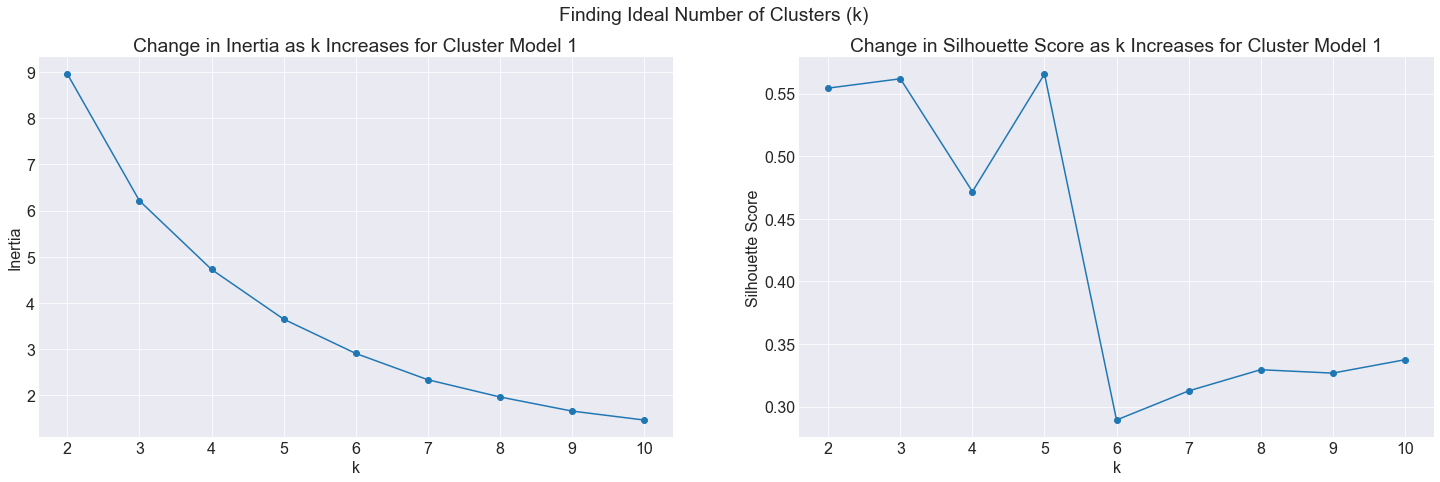

In [59]:
plt.figure(figsize=(25, 7)).suptitle('Finding Ideal Number of Clusters (k)')

kmax = 10

plt.subplot(121)

# let's plot inertia vs k for this model to chose number of clusters (k)

pd.Series({k: KMeans(k).fit(scaled_char_df).inertia_ for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Change in Inertia as k Increases for Cluster Model 1')


plt.subplot(122)

pd.Series({k: silhouette_score(scaled_char_df, KMeans(k).fit(scaled_char_df).labels_) for k in range(2, kmax+1)}).plot(marker='o')
plt.xticks(range(2, kmax+1))
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Change in Silhouette Score as k Increases for Cluster Model 1');


Lets try 5 clusters to start

In [63]:
# create model object
kmeans1 = KMeans(n_clusters=5, random_state=527)

# fit the object to scaled, training data
kmeans1.fit(scaled_char_df)

# Use (predict using) the thing 
char_df['cluster_1'] = kmeans1.predict(scaled_char_df)
scaled_char_df['cluster_1'] = kmeans1.predict(scaled_char_df)

In [65]:
char_df

pcnt_decrease  \
Religious, Grantmaking, Civic, Professional, an...      17.848536   
Leather and Allied Product Manufacturing                36.080586   
Clothing and Clothing Accessories Stores                61.838901   
Fabricated Metal Product Manufacturing                   5.999218   
Social Assistance                                       10.849785   
...                                                           ...   
Museums, Historical Sites, and Similar Institut...      17.764241   
Primary Metal Manufacturing                              3.834104   
Food Manufacturing                                       7.178646   
Administration of Environmental Quality Programs         0.989598   
General Merchandise Stores                               6.061442   

                                                    recovery_slope  \
Religious, Grantmaking, Civic, Professional, an...          1501.5   
Leather and Allied Product Manufacturing                     200.5   
Clothing and Clothing Accessories Stores                   20903.5   
Fabricated Metal Product Manufacturing                     -1269.0   
Social Assistance                                           4169.5   
...                                                            ...   
Museums, Historical Sites, and Similar Institut...          1967.0   
Primary Metal Manufacturing                                 -271.5   
Food Manufacturing                                          2591.5   
Administration of Environmental Quality Programs             165.5   
General Merchandise Stores                                  7813.0   

                                                             mean  \
Religious, Grantmaking, Civic, Professional, an...   55410.333333   
Leather and Allied Product Manufacturing              3816.000000   
Clothing and Clothing Accessories Stores             94593.750000   
Fabricated Metal Product Manufacturing              120391.500000   
Social Assistance                                   250081.000000   
...                                                           ...   
Museums, Historical Sites, and Similar Institut...   27225.333333   
Primary Metal Manufacturing                          19128.750000   
Food Manufacturing                                   98796.916667   
Administration of Environmental Quality Programs     14070.750000   
General Merchandise Stores                          275678.666667   

                                                    standard_dev  \
Religious, Grantmaking, Civic, Professional, an...   4538.925671   
Leather and Allied Product Manufacturing              567.876267   
Clothing and Clothing Accessories Stores            22972.835817   
Fabricated Metal Product Manufacturing               6908.612418   
Social Assistance                                   11203.305137   
...                                                          ...   
Museums, Historical Sites, and Similar Institut...   2239.564135   
Primary Metal Manufacturing                           700.099490   
Food Manufacturing                                   2797.390000   
Administration of Environmental Quality Programs      251.282935   
General Merchandise Stores                          11848.367278   

                                                    recovery_slope_normalized  \
Religious, Grantmaking, Civic, Professional, an...                   0.027098   
Leather and Allied Product Manufacturing                             0.052542   
Clothing and Clothing Accessories Stores                             0.220982   
Fabricated Metal Product Manufacturing                              -0.010541   
Social Assistance                                                    0.016673   
...                                                                       ...   
Museums, Historical Sites, and Similar Institut...                   0.072249   
Primary Metal Manufacturing                                         -0.014193   
Food Ma

In [72]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, Religious, Grantmaking, Civic, Professional, and Similar Organizations to General Merchandise Stores 
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pcnt_decrease              96 non-null     float64
 1   recovery_slope             96 non-null     float64
 2   mean                       96 non-null     float64
 3   standard_dev               96 non-null     float64
 4   recovery_slope_normalized  96 non-null     float64
 5   cov                        96 non-null     float64
 6   cluster_1                  96 non-null     int32  
dtypes: float64(6), int32(1)
memory usage: 5.6+ KB


In [76]:
for cluster, subset in char_df.groupby('cluster_1'):
    print(cluster)
    print(len(subset))

0
72
1
8
2
11
3
4
4
1


In [77]:
char_df.groupby('cluster_1').count()

pcnt_decrease  recovery_slope  mean  standard_dev  \
cluster_1                                                      
0                     72              72    72            72   
1                      8               8     8             8   
2                     11              11    11            11   
3                      4               4     4             4   
4                      1               1     1             1   

           recovery_slope_normalized  cov  
cluster_1                                  
0                                 72   72  
1                                  8    8  
2                                 11   11  
3                                  4    4  
4                                  1    1

ValueError: x and y must be the same size

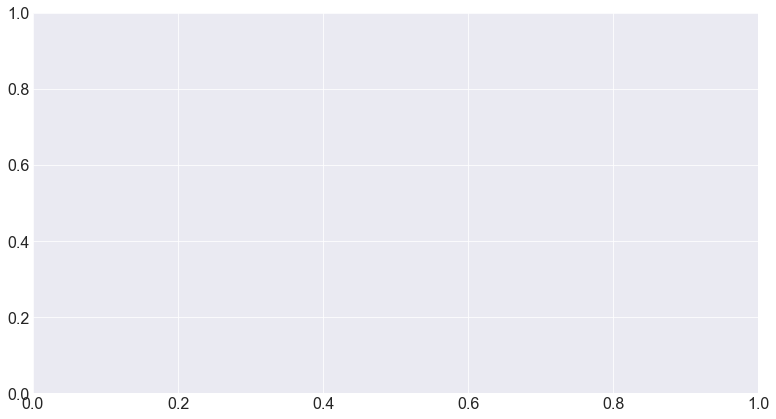

In [71]:
# plot in 2d
for cluster, subset in char_df.groupby('cluster_1'):
    plt.scatter(x=subset.pcnt_decrease, y=subset.mean, label='cluster ' + str(cluster), alpha=.5, cmap='reds')
plt.legend()
# plt.xlabel('Petal Length')
# plt.ylabel('Petal Width')
plt.title('Visualizing Clusters')

In [67]:
# # 3d plots
# plt.figure(figsize=(10, 10))

# ax = plt.subplot(111, projection='3d')

# for cluster, subset in char_df.groupby('cluster_1'):
#     ax.scatter(xs=subset.pcnt_decrease, ys=subset.recovery_slope_normalized, zs=subset.cov, label='cluster ' + str(cluster), alpha=.5, cmap='reds')
# plt.legend()
# ax.set_xlabel('Percent Decrease', labelpad=16)
# ax.set_ylabel('Recovery Slope', labelpad=16)
# ax.set_zlabel('COV', labelpad=16)
# # ax.zaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
# plt.title('Visualizing Clusters for Cluster Model 1');

---
## Different ways to customize colors of lines
---

In [40]:
# check matplotlib version
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.3.4


In [41]:
# get a cmap and pull out colors from it to save to a list and use with cycler
cmap = matplotlib.cm.get_cmap('gist_rainbow')
cmap

In [42]:
# check number of lines needed here
len(ind_list)

1

In [43]:
# get list of colors
colors = [cmap(i) for i in np.linspace(0, 1, 12)]

In [44]:
# use cm.rainbow to generate another list of colors
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, 12))

In [45]:
# # do the same thing for wages
# from cycler import cycler


# plt.gca().set_prop_cycle(cycler('color', colors))
# for ind in ind_list:
#     df_dict[ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].plot(label=ind)
# plt.gca().set(ylabel = 'Total Employment', title='Level 1 Industries')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}M'.format(x / 1_000_000))
# plt.legend(bbox_to_anchor= (1.03,1));